In [1]:
# ── imports ──────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# generation
from lhcb_velo_toy.generation import (
    PlaneGeometry,
    StateEventGenerator,
)

# solvers
from lhcb_velo_toy.solvers import (
    SimpleHamiltonianFast,
    get_tracks,
)

# analysis
from lhcb_velo_toy.analysis import EventValidator, Match
from lhcb_velo_toy.analysis.plotting.event_display import (
    plot_event_3d,
    plot_reco_vs_truth,
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# ── helper: build geometry from high-level parameters ───────────
def make_geometry(n_modules: int, z_first: float = 100.0, z_spacing: float = 33.0,
                  half_x: float = 50.0, half_y: float = 50.0) -> PlaneGeometry:
    """Create a PlaneGeometry with evenly spaced modules."""
    z_positions = [z_first + i * z_spacing for i in range(n_modules)]
    return PlaneGeometry(
        module_id=list(range(n_modules)),
        lx=[half_x] * n_modules,
        ly=[half_y] * n_modules,
        z=z_positions,
    )

# ── helper: generate a complete event ───────────────────────────
def generate_event(geo, n_tracks, measurement_error=0.0, collision_noise=1e-8,
                   phi_max=0.2, theta_max=0.2):
    """Generate a full event end-to-end."""
    gen = StateEventGenerator(
        detector_geometry=geo,
        events=1,
        n_particles=[n_tracks],
        phi_min=-phi_max, phi_max=phi_max,
        theta_min=-theta_max, theta_max=theta_max,
        measurement_error=measurement_error,
        collision_noise=collision_noise,
    )
    gen.generate_random_primary_vertices({"x": 0.1, "y": 0.1, "z": 50.0})
    particles = [[{"type": "pion", "mass": 139.6, "q": 1}] * n_tracks]
    gen.generate_particles(particles)
    event = gen.generate_complete_events()
    return gen, event

# ── helper: compute epsilon from physics parameters ─────────────
def compute_epsilon(sigma_res, sigma_scatt, dz, scale=1.0, theta_min=1.5e-5):
    """Compute angular acceptance threshold epsilon.

    Uses the paper formula with weighting factors:
        epsilon = scale * sqrt(2*theta_s^2 + 12*theta_r^2 + 2*theta_min^2)

    Parameters
    ----------
    sigma_res : float
        Measurement resolution (same units as dz, e.g. mm).
    sigma_scatt : float
        Multiple scattering angle (radians).
    dz : float
        Module spacing (same units as sigma_res).
    scale : float
        Number of sigma to accept (default 1.0).
    theta_min : float
        Minimum threshold to avoid numerical instability (rad).

    Returns
    -------
    float
        Epsilon threshold in radians.
    """
    theta_s = scale * sigma_scatt
    theta_r = np.arctan((scale * sigma_res) / dz) if dz != 0 else 0.0
    return float(np.sqrt(2 * theta_s**2 + 12 * theta_r**2 + 2 * theta_min**2))


# ── helper: pairwise angle between consecutive segments ────────
def pairwise_angle(h_prev, h_mid, h_next):
    """Angle between segment (prev->mid) and segment (mid->next).

    This is exactly what the Hamiltonian evaluates for segment pairs
    sharing a middle hit. It is NOT the angle w.r.t. the beam axis.
    """
    v1 = np.array([h_mid.x - h_prev.x, h_mid.y - h_prev.y, h_mid.z - h_prev.z])
    v2 = np.array([h_next.x - h_mid.x, h_next.y - h_mid.y, h_next.z - h_mid.z])
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return 0.0
    cos_a = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return float(np.arccos(cos_a))


def collect_segment_pair_angles(event):
    """Collect pairwise angles for ALL segment pairs sharing a middle hit.

    A 'true' pair means all 3 hits (prev, mid, next) are on the SAME track.
    Returns (true_angles, false_angles) as lists.
    """
    hits_dict = {h.hit_id: h for h in event.hits}

    # Build true segment set
    true_seg_set = set()
    for trk in event.tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 1):
            true_seg_set.add((hids[k], hids[k + 1]))

    # Group hits by module
    hits_by_module = {}
    for h in event.hits:
        hits_by_module.setdefault(h.module_id, []).append(h)
    sorted_mod_ids = sorted(hits_by_module.keys())

    true_angles = []
    false_angles = []

    # For each MIDDLE module, pair incoming and outgoing segments
    for mi in range(1, len(sorted_mod_ids) - 1):
        mod_prev = sorted_mod_ids[mi - 1]
        mod_mid  = sorted_mod_ids[mi]
        mod_next = sorted_mod_ids[mi + 1]

        for h_mid in hits_by_module[mod_mid]:
            for h_prev in hits_by_module[mod_prev]:
                seg_in_true = (h_prev.hit_id, h_mid.hit_id) in true_seg_set

                for h_next in hits_by_module[mod_next]:
                    seg_out_true = (h_mid.hit_id, h_next.hit_id) in true_seg_set
                    angle = pairwise_angle(h_prev, h_mid, h_next)

                    # True pair: both segments true AND all 3 hits on SAME track
                    if (seg_in_true and seg_out_true and
                            h_prev.track_id is not None and
                            h_prev.track_id == h_mid.track_id == h_next.track_id):
                        true_angles.append(angle)
                    else:
                        false_angles.append(angle)

    return true_angles, false_angles


print("All imports and helpers loaded.")

All imports and helpers loaded.


In [2]:
# ── generate a clean event ──────────────────────────────────────
N_TRACKS_CLEAN = 3
N_MODULES_CLEAN = 5

geo_clean = make_geometry(N_MODULES_CLEAN, z_spacing=33.0)

for attempt in range(20):
    gen_clean, event_clean = generate_event(geo_clean, N_TRACKS_CLEAN)
    min_hits = min(len(t.hit_ids) for t in event_clean.tracks)
    if min_hits >= 3:
        break

print(f"Clean event: {len(event_clean.tracks)} tracks, "
      f"{len(event_clean.hits)} hits across {len(event_clean.modules)} modules")
for trk in event_clean.tracks:
    print(f"  Track {trk.track_id}: {len(trk.hit_ids)} hits")

Clean event: 3 tracks, 15 hits across 5 modules
  Track 0: 5 hits
  Track 1: 5 hits
  Track 2: 5 hits


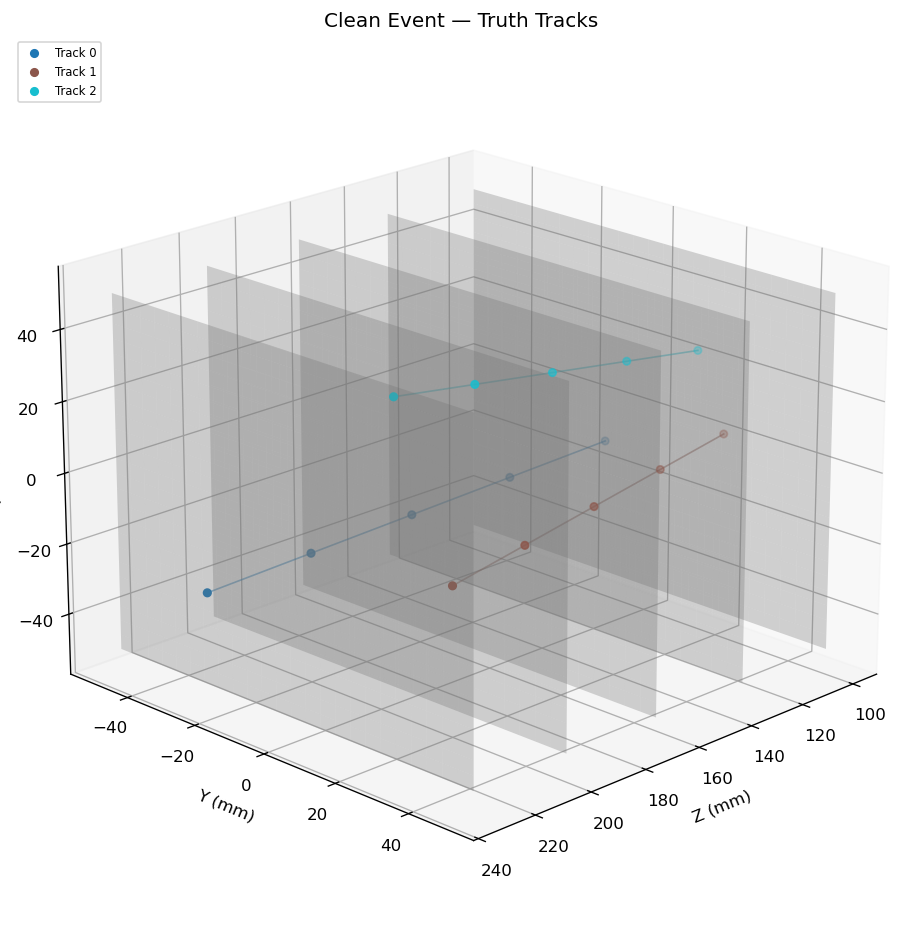

In [3]:
# ── 3-D truth display ───────────────────────────────────────────
fig_truth = plot_event_3d(event_clean, title="Clean Event — Truth Tracks")
plt.show()

In [4]:
# ── build Hamiltonian & solve classically ────────────────────────
SIGMA_RES   = 0.0     # measurement resolution (mm) — 0 for clean event
SIGMA_SCATT = 1e-3    # collision noise (rad)
DZ_MM       = 33.0    # module spacing (mm)
SCALE       = 3.0     # accept segment pairs within 3 sigma

EPSILON = compute_epsilon(SIGMA_RES, SIGMA_SCATT, DZ_MM, scale=SCALE)
GAMMA   = 1.5    # self-interaction penalty
DELTA   = 1.0    # bias weight

print(f"Computed epsilon = {EPSILON:.6f} rad ({EPSILON*1e3:.3f} mrad)")

ham_clean = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
A_clean, b_clean = ham_clean.construct_hamiltonian(event_clean)
x_clean = ham_clean.solve_classicaly()

BASELINE  = DELTA / (DELTA + GAMMA)
THRESHOLD = (1 + BASELINE) / 2

print(f"Segments:  {ham_clean.n_segments}")
print(f"Matrix A:  {A_clean.shape[0]}x{A_clean.shape[1]}, nnz={A_clean.nnz}")
print(f"Uncoupled baseline:  x ~ {BASELINE:.3f}")
print(f"Threshold:           {THRESHOLD:.3f}")
print(f"Active (above thr):  {np.sum(x_clean > THRESHOLD)} / {len(x_clean)} segments")
print(f"Min / Max activation: {x_clean.min():.4f} / {x_clean.max():.4f}")

Computed epsilon = 0.004243 rad (4.243 mrad)
Segments:  36
Matrix A:  36x36, nnz=54
Uncoupled baseline:  x ~ 0.400
Threshold:           0.700
Active (above thr):  12 / 36 segments
Min / Max activation: 0.4000 / 1.2727


In [5]:
# ── reconstruct tracks ──────────────────────────────────────────
reco_clean = get_tracks(ham_clean, x_clean, event_clean, threshold=THRESHOLD)
print(f"Reconstructed {len(reco_clean)} tracks")
for trk in reco_clean:
    print(f"  Reco track {trk.track_id}: {len(trk.hit_ids)} hits")

Reconstructed 3 tracks
  Reco track 0: 5 hits
  Reco track 1: 5 hits
  Reco track 2: 5 hits


In [6]:
# ── validate: match reco -> truth ────────────────────────────
val_clean = EventValidator(event_clean, reco_clean)
matches_clean, metrics_clean = val_clean.match_tracks(purity_min=0.7)

print("=== Clean Event Metrics ===")
for k, v in metrics_clean.items():
    print(f"  {k:25s}: {v}")

print("\nPer-track matches:")
print(f"  {'Truth':>6}  {'RecHits':>7}  {'Purity':>7}  {'HitEff':>7}  {'Type'}")
for m in matches_clean:
    label = "PRIMARY" if m.is_primary else ("GHOST" if m.is_ghost else "CLONE")
    truth_str = str(m.truth_id) if m.truth_id is not None else "-"
    print(f"  {truth_str:>6}  {m.rec_hits:7d}  "
          f"{m.purity:7.3f}  {m.hit_efficiency:7.3f}  {label}")

=== Clean Event Metrics ===
  efficiency               : 1.0
  ghost_rate               : 0.0
  clone_fraction           : 0.0
  mean_purity              : 1.0
  hit_efficiency           : 1.0
  n_candidates             : 3
  n_accepted               : 3
  n_ghosts                 : 0
  n_clones                 : 0
  n_primary                : 3
  n_reconstructible        : 3
  n_matched                : 3

Per-track matches:
   Truth  RecHits   Purity   HitEff  Type
       0        5    1.000    1.000  PRIMARY
       1        5    1.000    1.000  PRIMARY
       2        5    1.000    1.000  PRIMARY


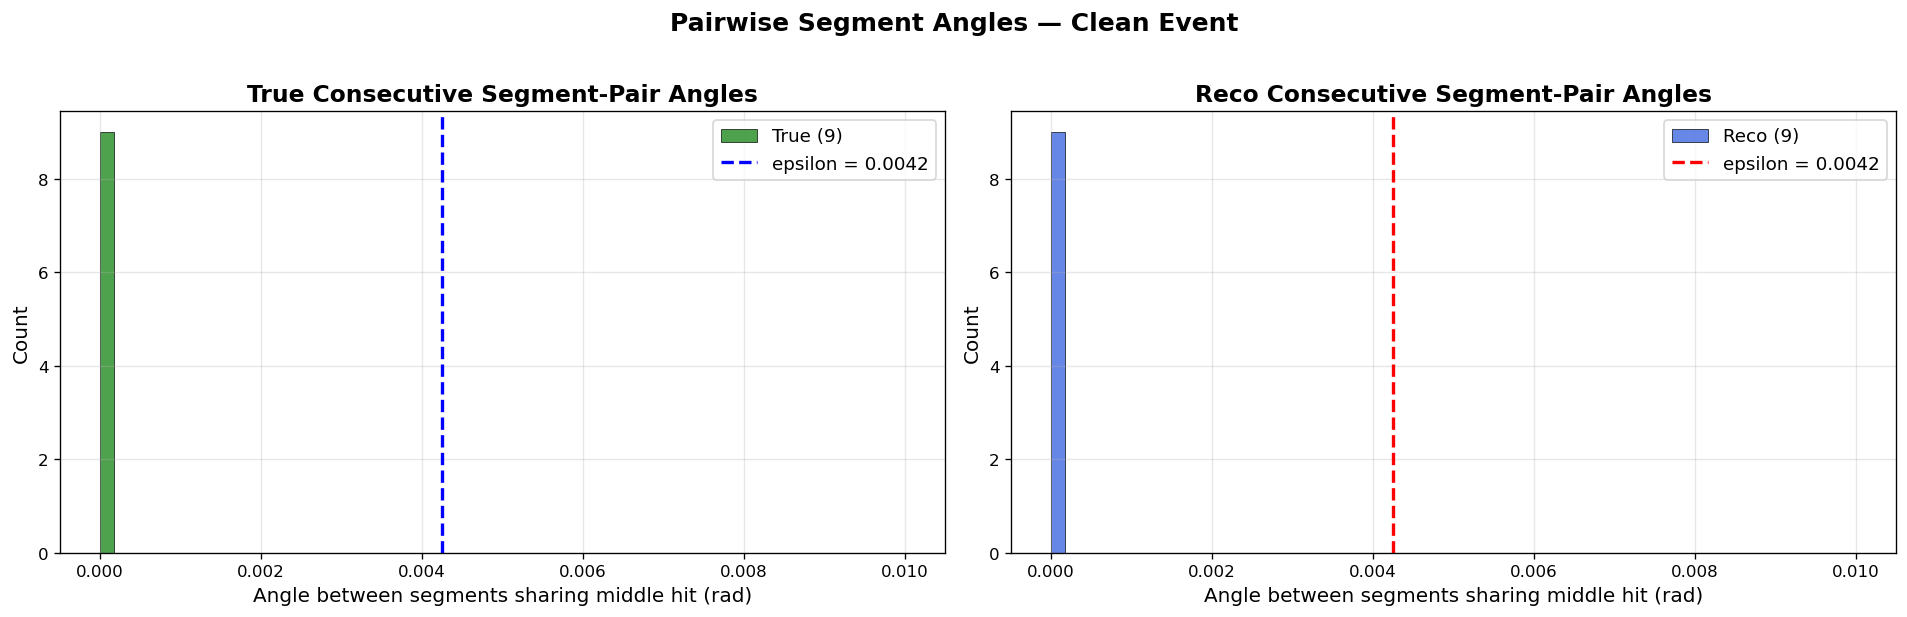

True pairs:  9, mean = 0.000000 rad (0.000 mrad)
Reco pairs:  9, mean = 0.000000 rad (0.000 mrad)
epsilon    = 0.004243 rad (4.243 mrad)


In [7]:
# ── Pairwise segment angles (shared middle hit) — Clean event ─
# The Hamiltonian checks the angle BETWEEN consecutive segments
# sharing a middle hit, NOT the angle w.r.t. the beam axis.

hits_dict_clean = {hit.hit_id: hit for hit in event_clean.hits}

def pairwise_angles_from_tracks(tracks, hits_dict):
    """Angles between consecutive segment pairs on each track.
    For hits [h0, h1, h2, h3]: angle(h0->h1, h1->h2), angle(h1->h2, h2->h3).
    """
    angles = []
    for trk in tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 2):
            h0 = hits_dict[hids[k]]
            h1 = hits_dict[hids[k + 1]]
            h2 = hits_dict[hids[k + 2]]
            angles.append(pairwise_angle(h0, h1, h2))
    return np.array(angles) if angles else np.array([])

true_seg_angles_clean = pairwise_angles_from_tracks(event_clean.tracks, hits_dict_clean)
reco_seg_angles_clean = pairwise_angles_from_tracks(reco_clean, hits_dict_clean)

# Plot
hi = max(0.01, max(true_seg_angles_clean.max() if len(true_seg_angles_clean) else 0,
                   reco_seg_angles_clean.max() if len(reco_seg_angles_clean) else 0) * 1.5)
bins = np.linspace(0, hi, 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(true_seg_angles_clean, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.5, label=f'True ({len(true_seg_angles_clean)})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
axes[0].set_title('True Consecutive Segment-Pair Angles', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Angle between segments sharing middle hit (rad)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(fontsize=11); axes[0].grid(alpha=0.3)

axes[1].hist(reco_seg_angles_clean, bins=bins, color='royalblue', alpha=0.8,
             edgecolor='black', lw=0.5, label=f'Reco ({len(reco_seg_angles_clean)})')
axes[1].axvline(EPSILON, color='red', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
axes[1].set_title('Reco Consecutive Segment-Pair Angles', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Angle between segments sharing middle hit (rad)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend(fontsize=11); axes[1].grid(alpha=0.3)

plt.suptitle('Pairwise Segment Angles — Clean Event', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"True pairs:  {len(true_seg_angles_clean)}, mean = {true_seg_angles_clean.mean():.6f} rad ({true_seg_angles_clean.mean()*1e3:.3f} mrad)")
print(f"Reco pairs:  {len(reco_seg_angles_clean)}, mean = {reco_seg_angles_clean.mean():.6f} rad ({reco_seg_angles_clean.mean()*1e3:.3f} mrad)")
print(f"epsilon    = {EPSILON:.6f} rad ({EPSILON*1e3:.3f} mrad)")


=== Event 0: 2 tracks ===
  2 tracks, 10 hits
  Reconstructed 2 tracks


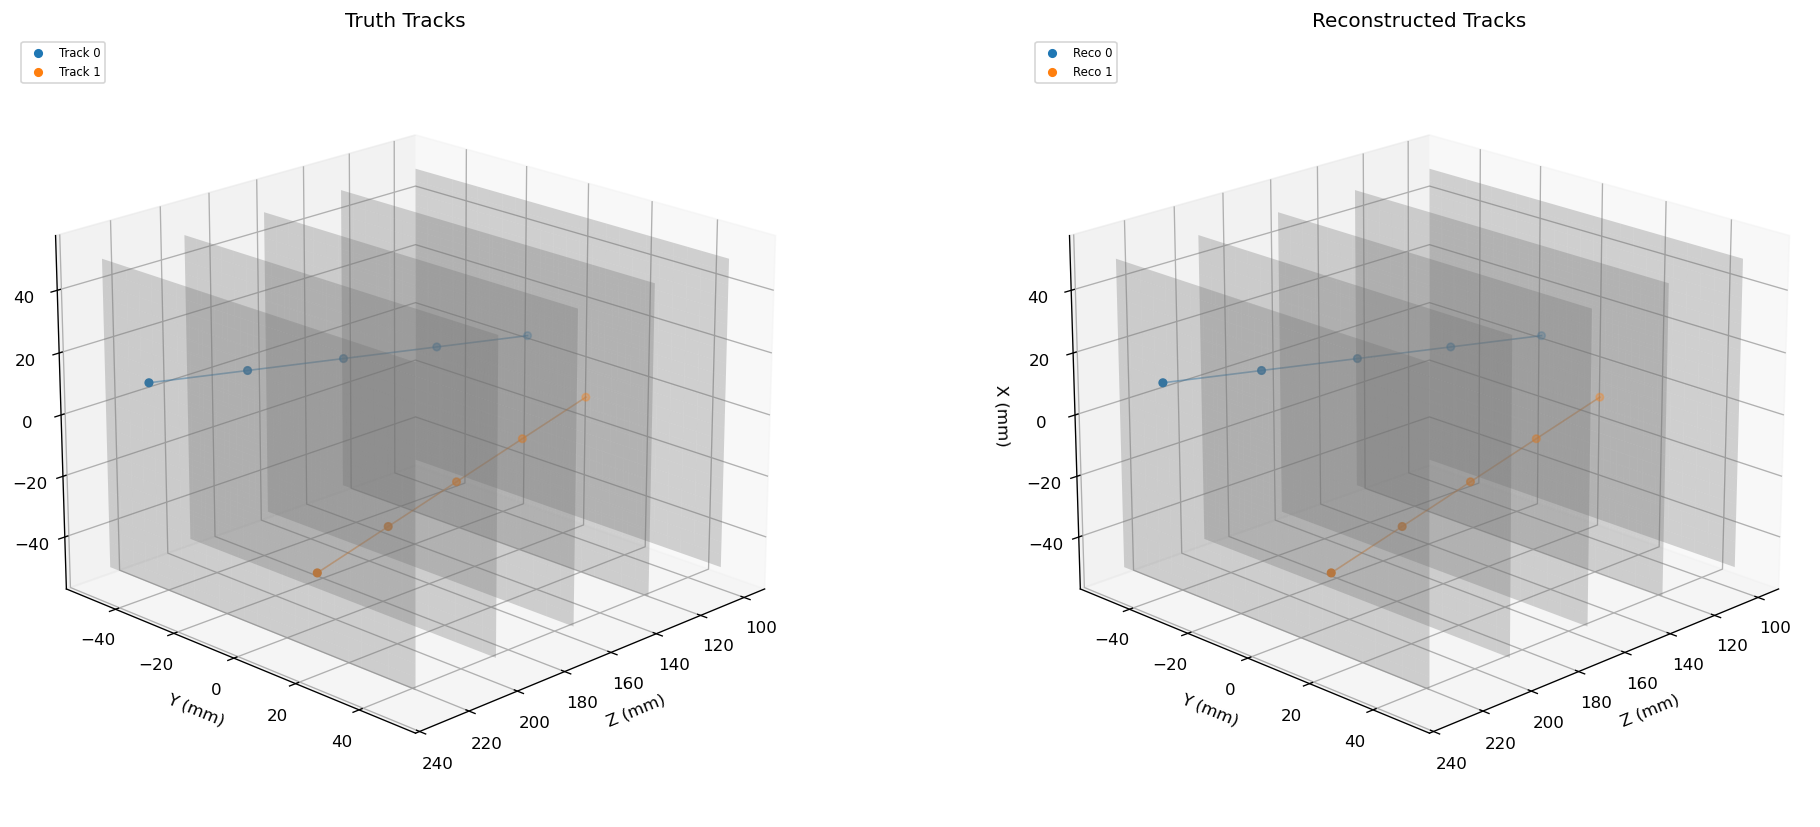


=== Event 1: 3 tracks ===
  3 tracks, 15 hits
  Reconstructed 3 tracks


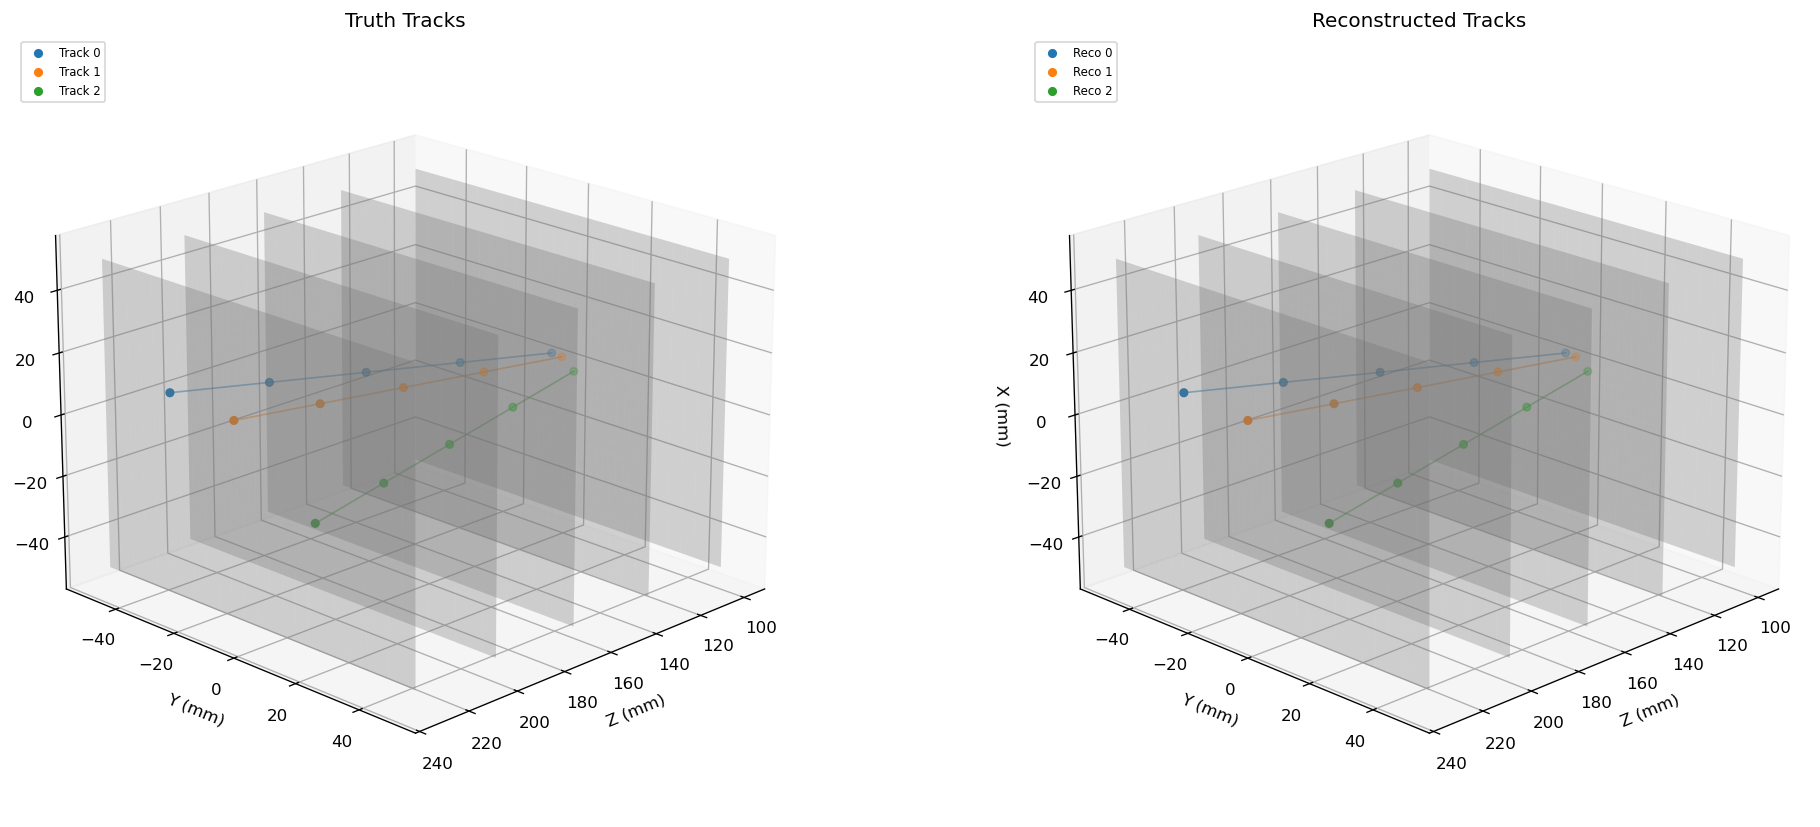


=== Event 2: 4 tracks ===
  4 tracks, 20 hits
  Reconstructed 4 tracks


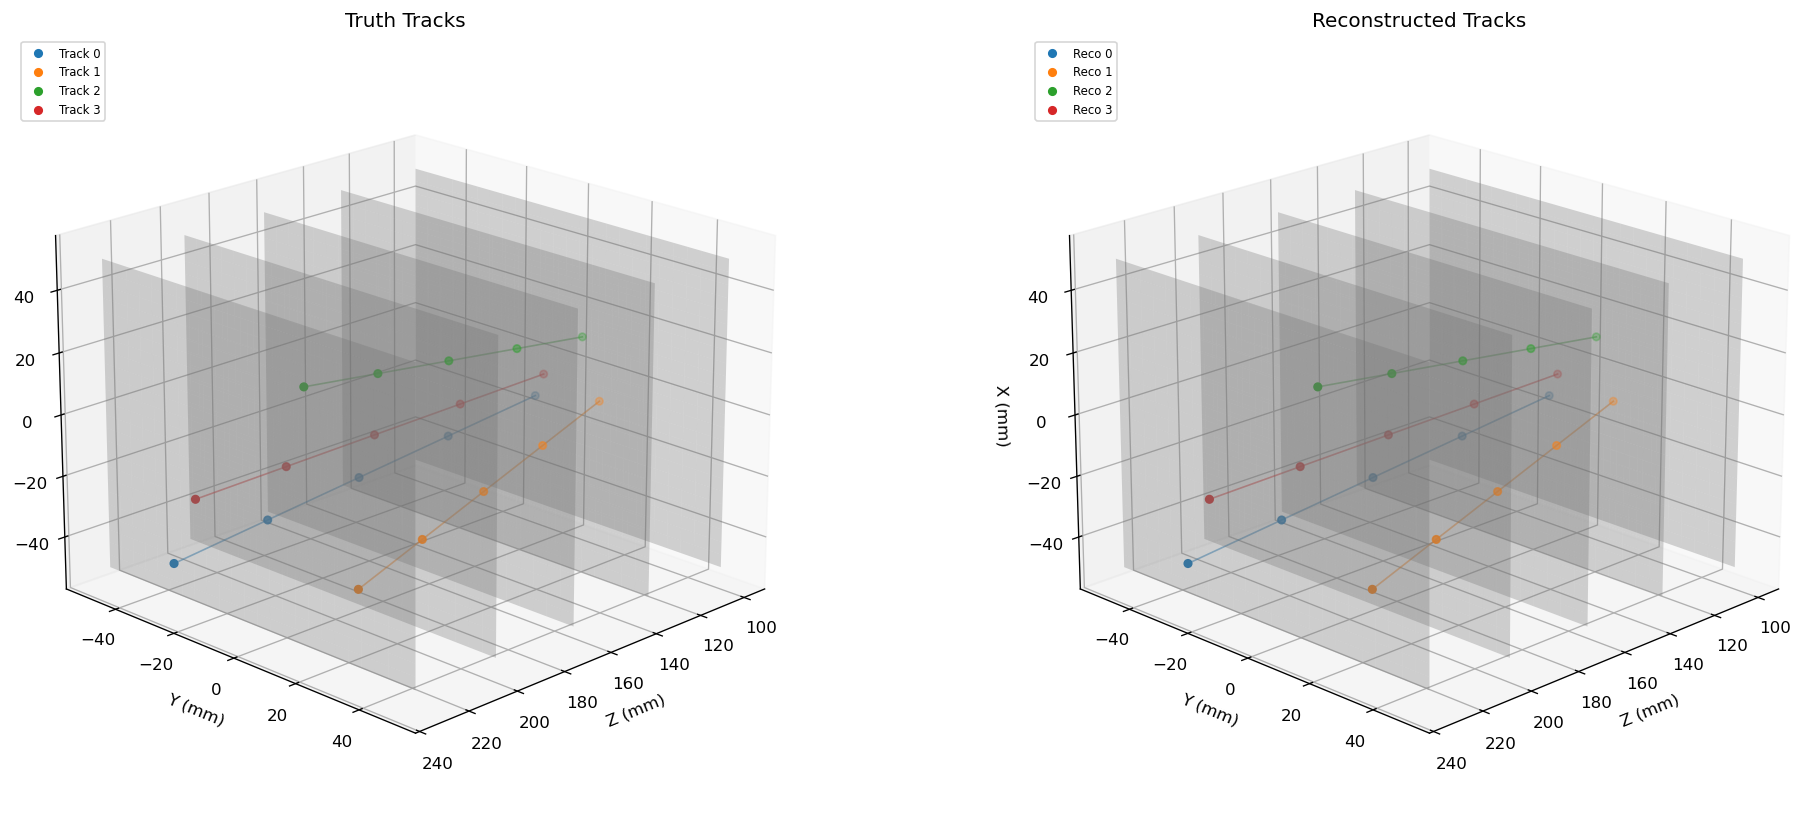


=== Event 3: 5 tracks ===
  5 tracks, 25 hits
  Reconstructed 3 tracks


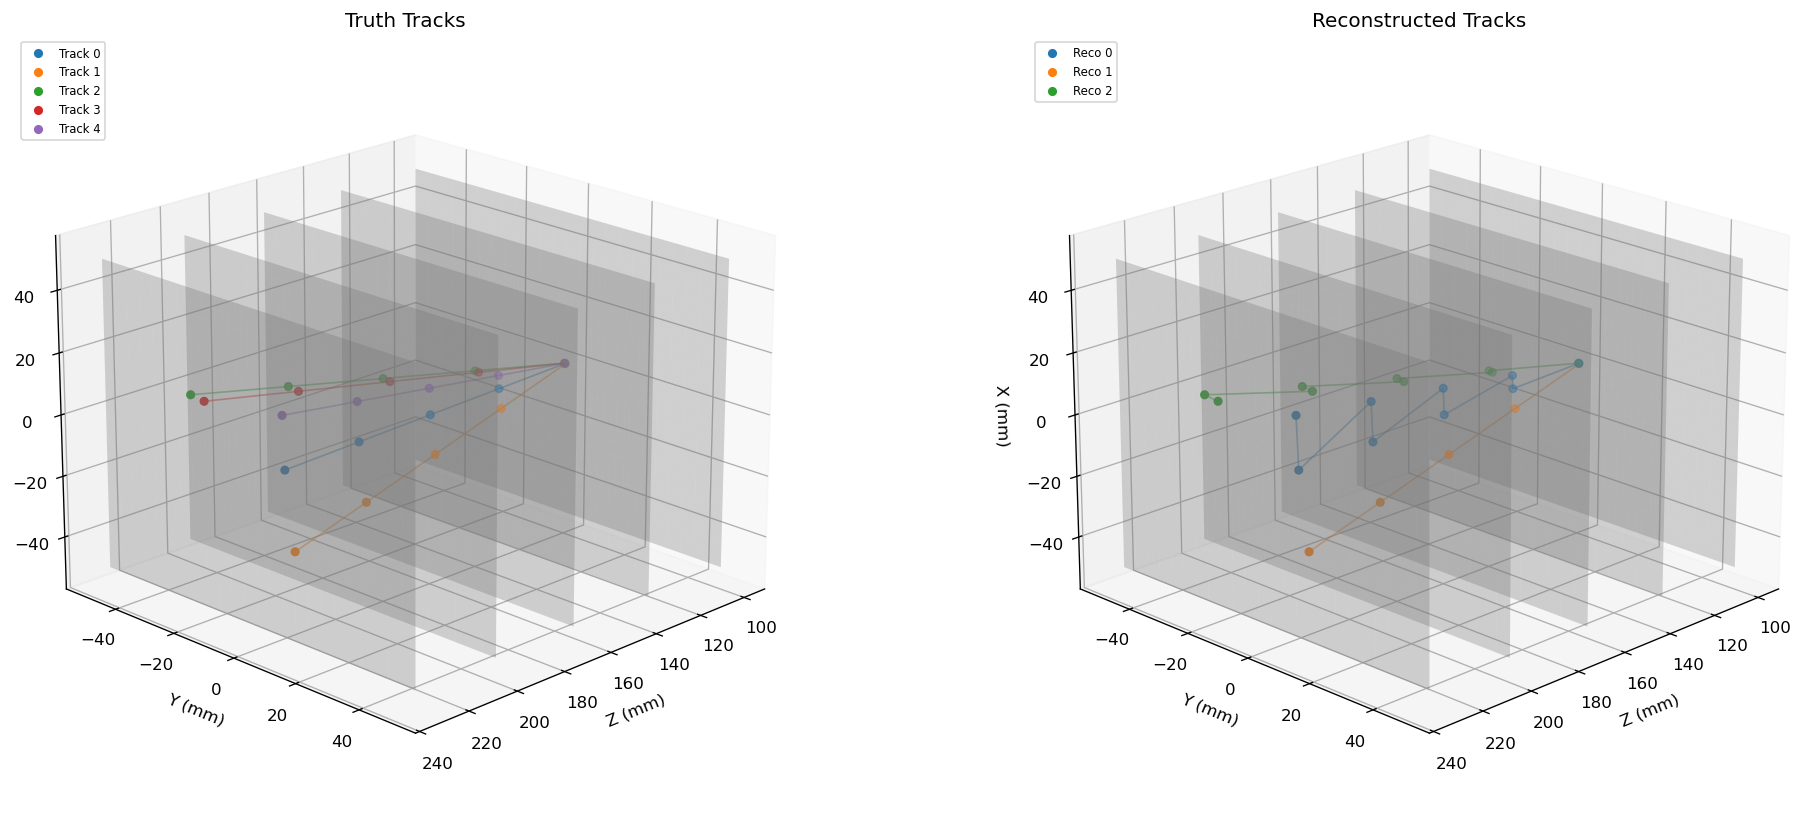


=== Event 4: 6 tracks ===
  6 tracks, 28 hits
  Reconstructed 5 tracks


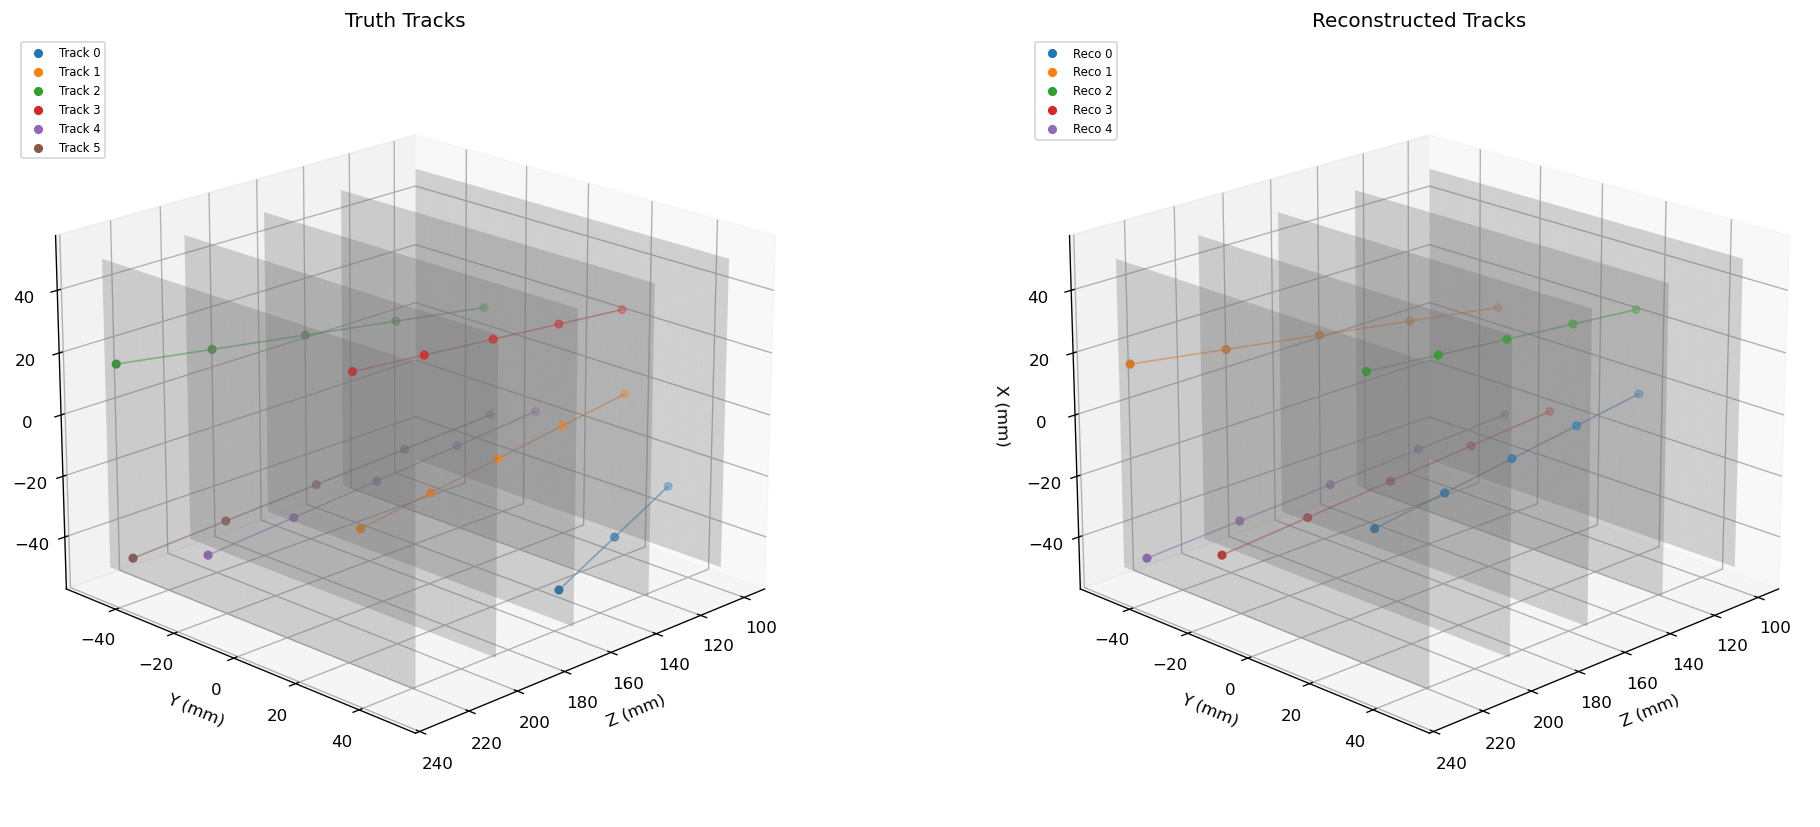


=== Event 5: 3 tracks ===
  3 tracks, 15 hits
  Reconstructed 3 tracks


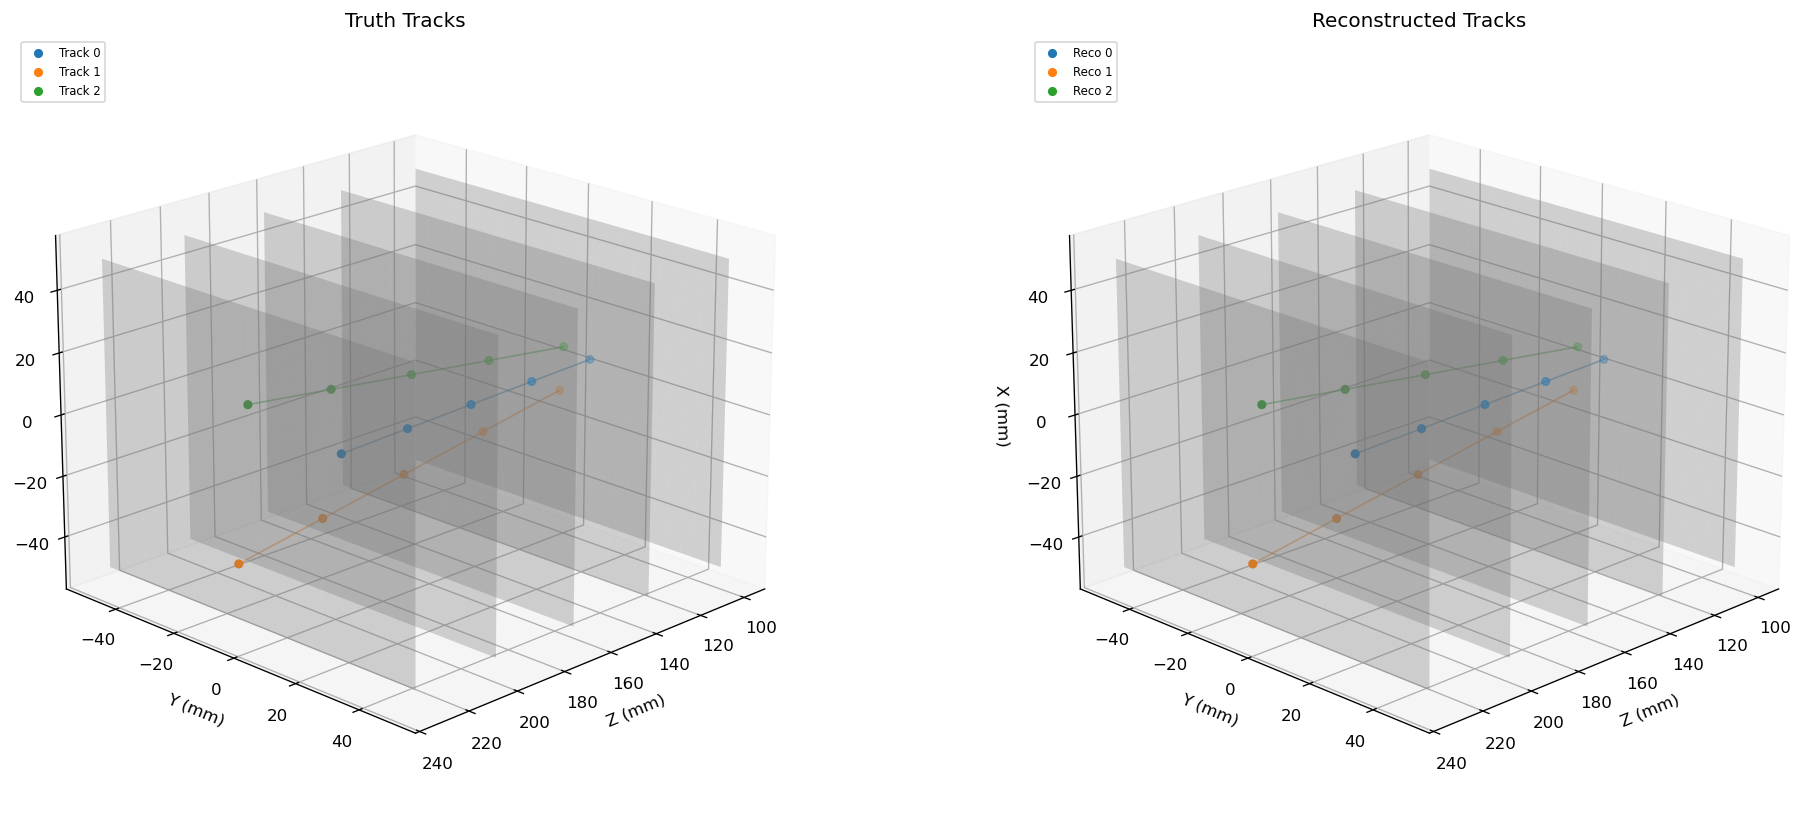


=== Event 6: 4 tracks ===
  4 tracks, 20 hits
  Reconstructed 4 tracks


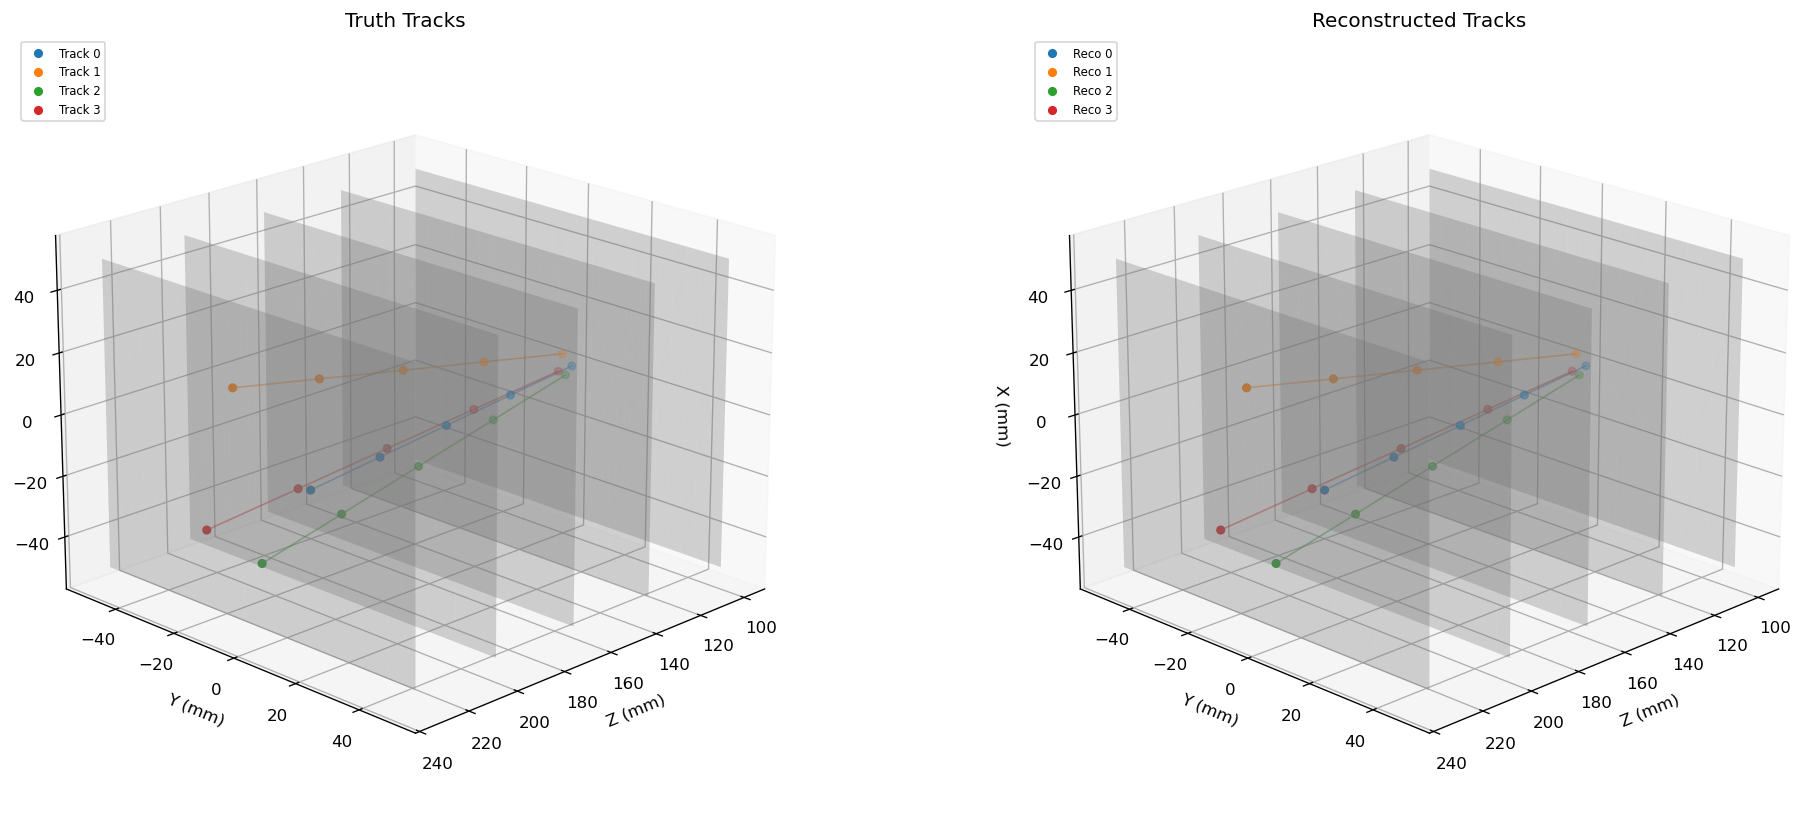


=== Event 7: 5 tracks ===
  5 tracks, 25 hits
  Reconstructed 5 tracks


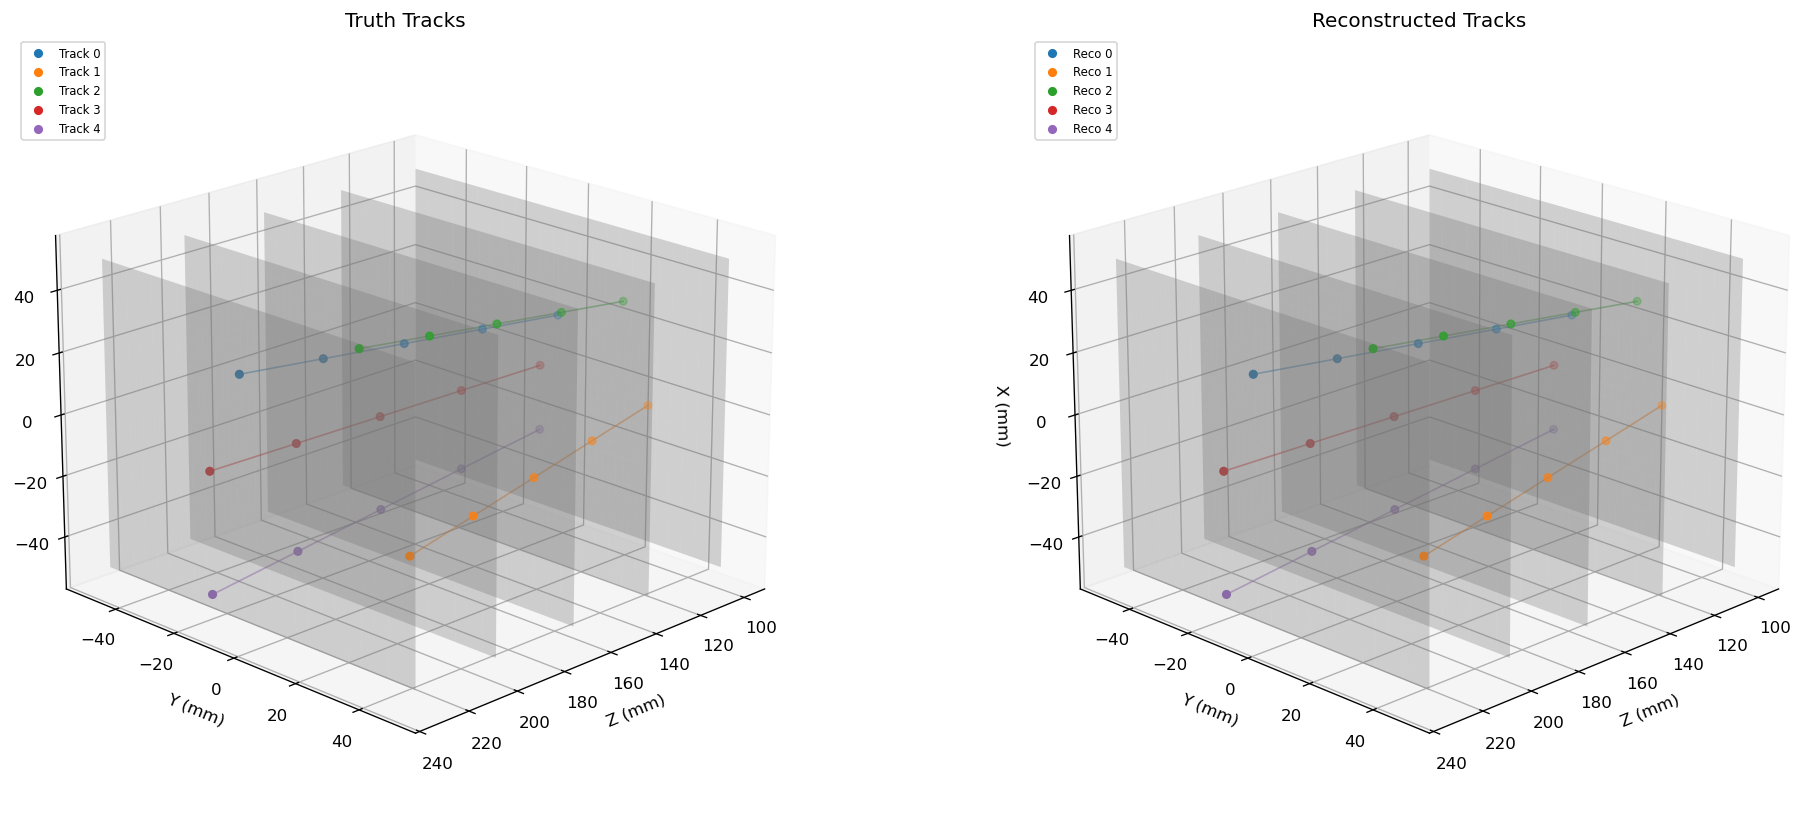


=== Event 8: 2 tracks ===
  2 tracks, 10 hits
  Reconstructed 2 tracks


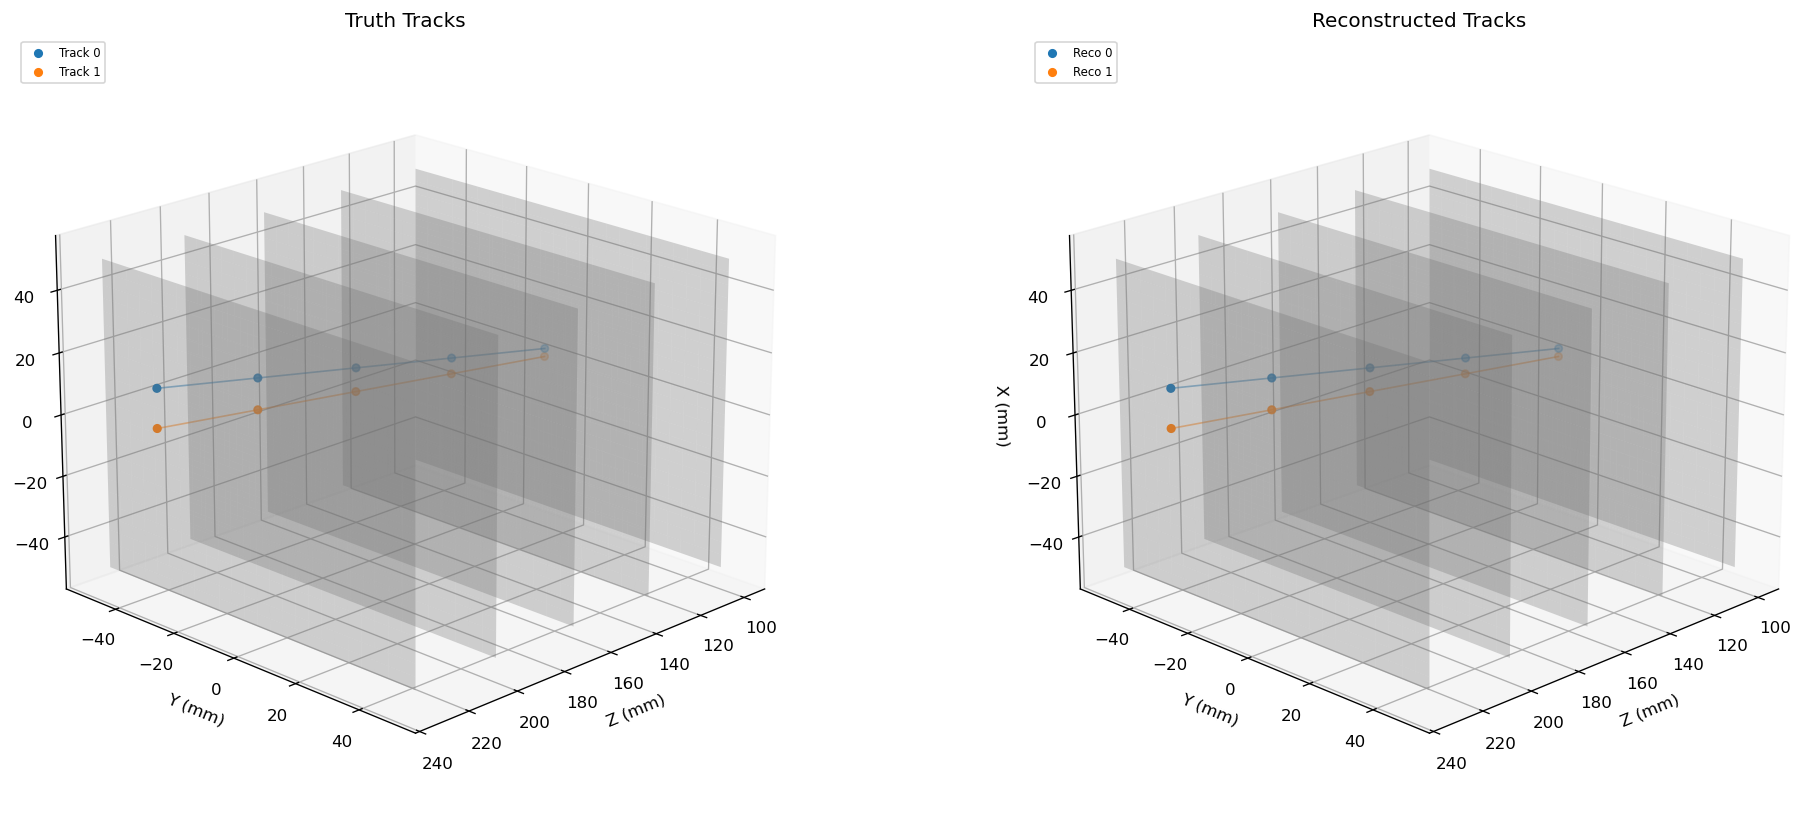


=== Event 9: 4 tracks ===
  4 tracks, 20 hits
  Reconstructed 4 tracks


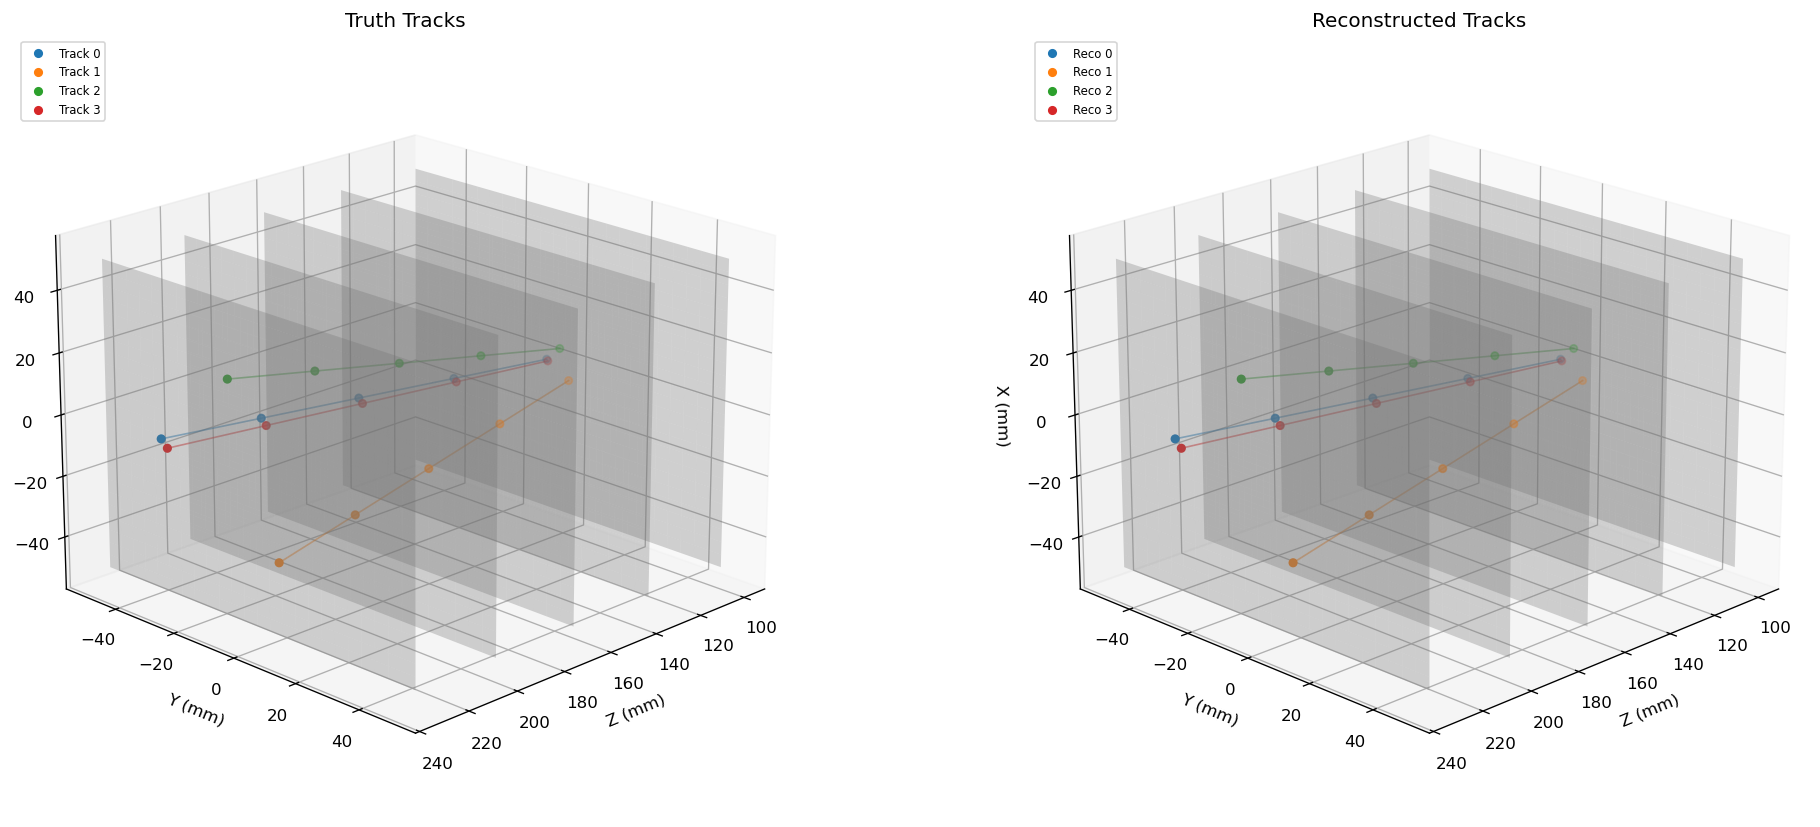


=== Summary ===
 Event   True   Reco     Eff   Ghost   TrueSeg   RecoSeg
     0      2      2   1.000   0.000         8         8
     1      3      3   1.000   0.000        12        12
     2      4      4   1.000   0.000        16        16
     3      5      3   0.200   0.667        20        22
     4      6      5   0.833   0.000        22        20
     5      3      3   1.000   0.000        12        12
     6      4      4   1.000   0.000        16        16
     7      5      5   1.000   0.000        20        20
     8      2      2   1.000   0.000         8         8
     9      4      4   1.000   0.000        16        16


In [8]:
# ── generate 10 events with varying track counts ────────────────
track_counts = [2, 3, 4, 5, 6, 3, 4, 5, 2, 4]
events_data = []

for i, n_tracks in enumerate(track_counts):
    print(f"\n=== Event {i}: {n_tracks} tracks ===")

    for attempt in range(20):
        gen, event = generate_event(geo_clean, n_tracks)
        min_hits = min(len(t.hit_ids) for t in event.tracks)
        if min_hits >= 3:
            break

    print(f"  {len(event.tracks)} tracks, {len(event.hits)} hits")

    ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
    A, b = ham.construct_hamiltonian(event)
    x = ham.solve_classicaly()

    reco_tracks = get_tracks(ham, x, event, threshold=THRESHOLD)
    print(f"  Reconstructed {len(reco_tracks)} tracks")

    true_segments = []
    for track in event.tracks:
        hit_ids = track.hit_ids
        for j in range(len(hit_ids) - 1):
            true_segments.append((hit_ids[j], hit_ids[j+1]))

    reco_segments = []
    for track in reco_tracks:
        hit_ids = track.hit_ids
        for j in range(len(hit_ids) - 1):
            reco_segments.append((hit_ids[j], hit_ids[j+1]))

    val = EventValidator(event, reco_tracks)
    matches, metrics = val.match_tracks(purity_min=0.7)

    events_data.append({
        'event_id': i,
        'n_tracks_true': len(event.tracks),
        'n_tracks_reco': len(reco_tracks),
        'event': event,
        'reco_tracks': reco_tracks,
        'true_segments': true_segments,
        'reco_segments': reco_segments,
        'matches': matches,
        'metrics': metrics,
        'ham': ham,
        'x': x
    })

    fig = plot_reco_vs_truth(event, reco_tracks)
    plt.show()

print("\n=== Summary ===")
print(f"{'Event':>6}  {'True':>5}  {'Reco':>5}  {'Eff':>6}  {'Ghost':>6}  {'TrueSeg':>8}  {'RecoSeg':>8}")
for ed in events_data:
    print(f"{ed['event_id']:6d}  {ed['n_tracks_true']:5d}  {ed['n_tracks_reco']:5d}  "
          f"{ed['metrics']['efficiency']:6.3f}  {ed['metrics']['ghost_rate']:6.3f}  "
          f"{len(ed['true_segments']):8d}  {len(ed['reco_segments']):8d}")

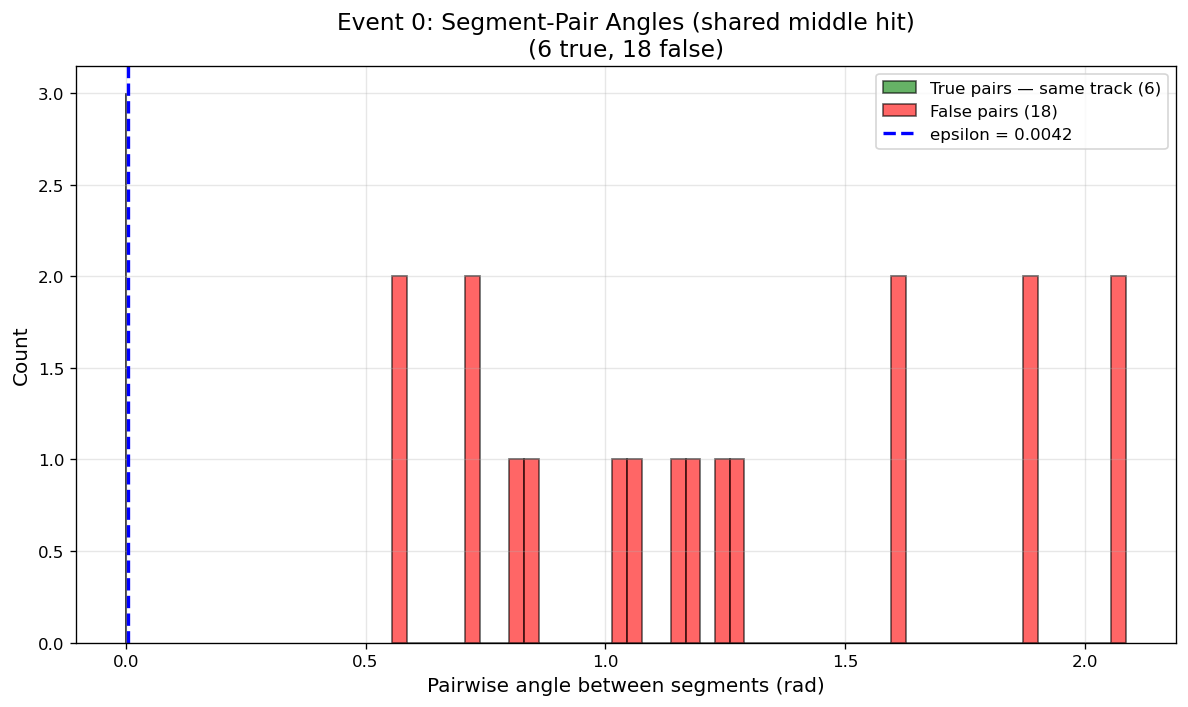

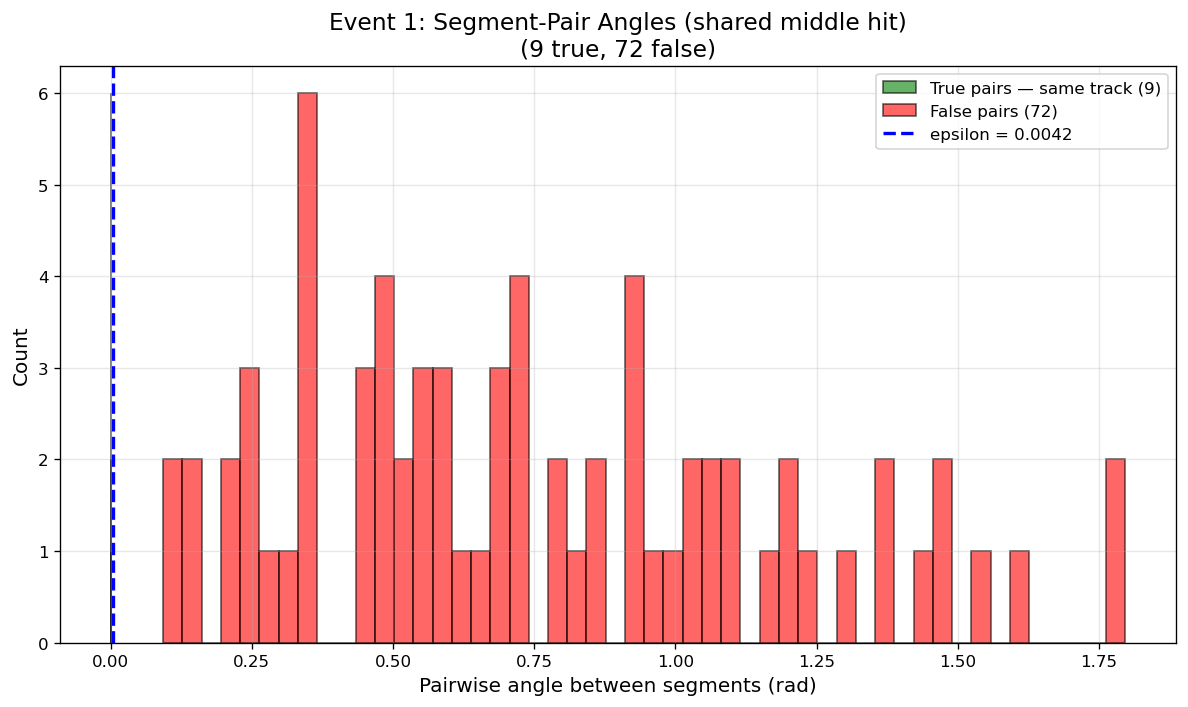

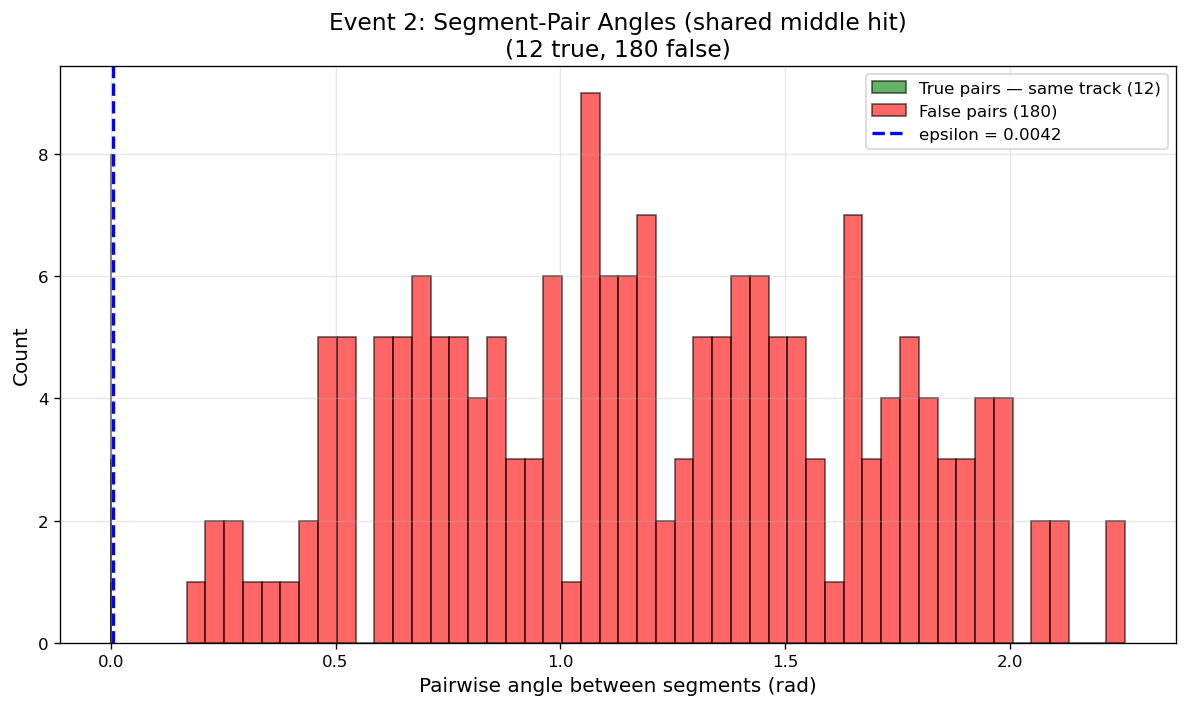

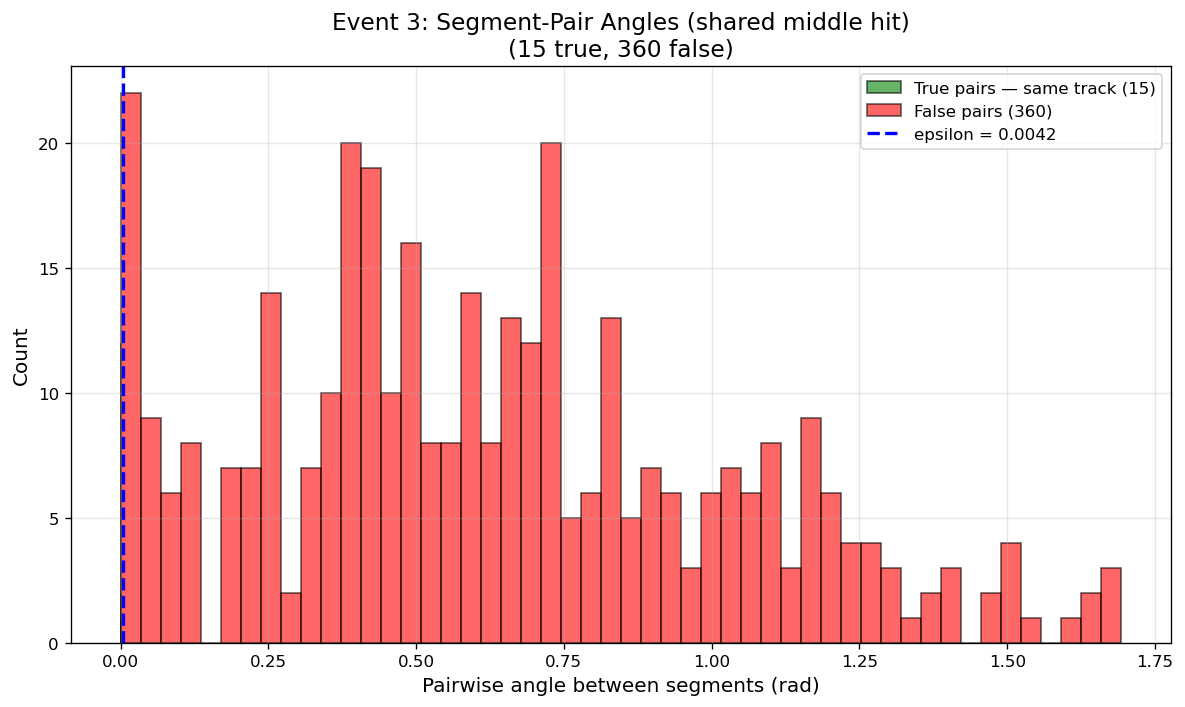

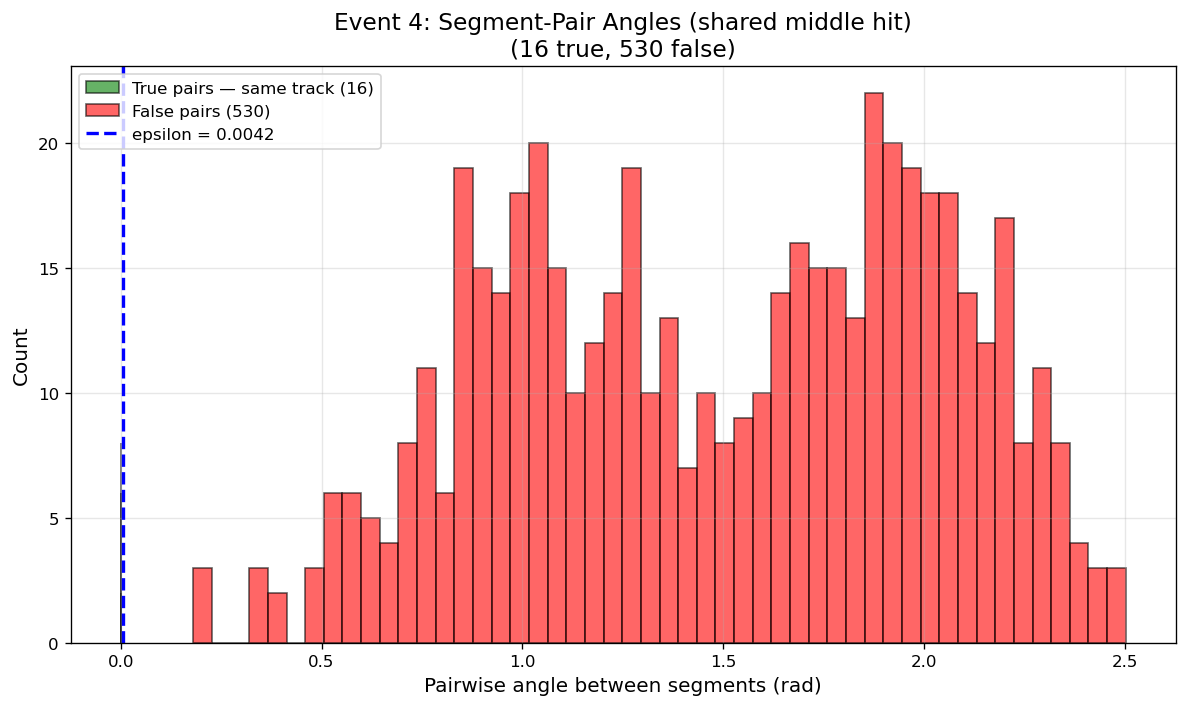

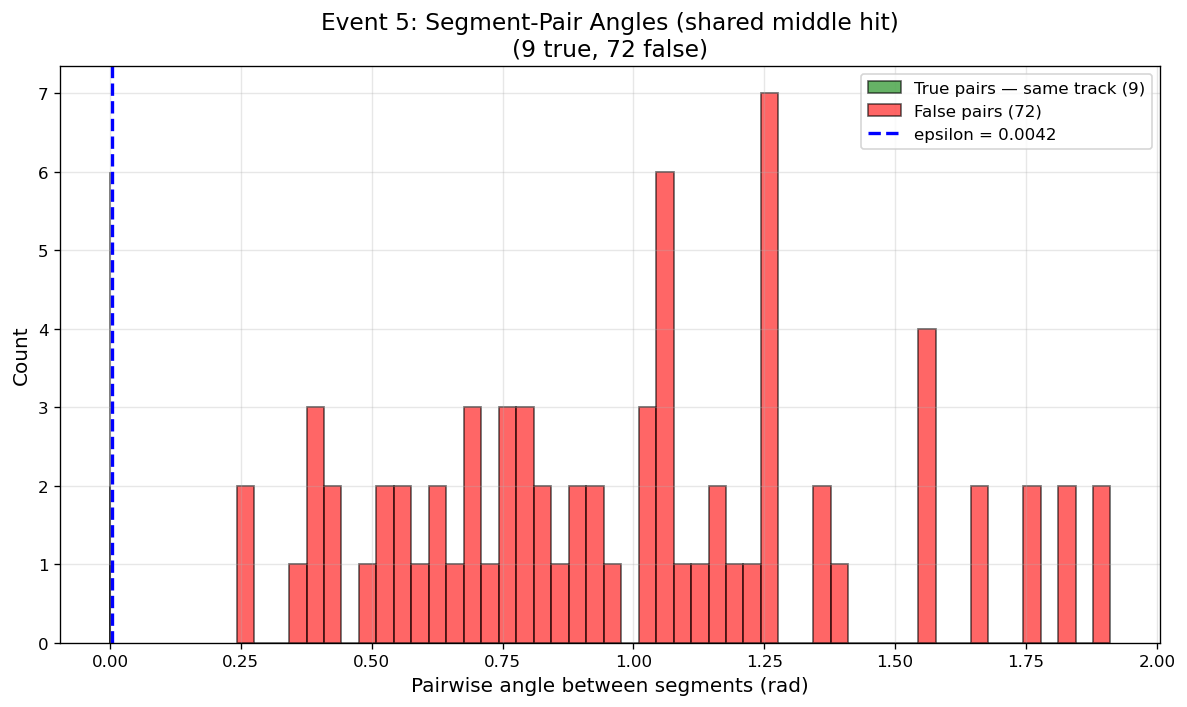

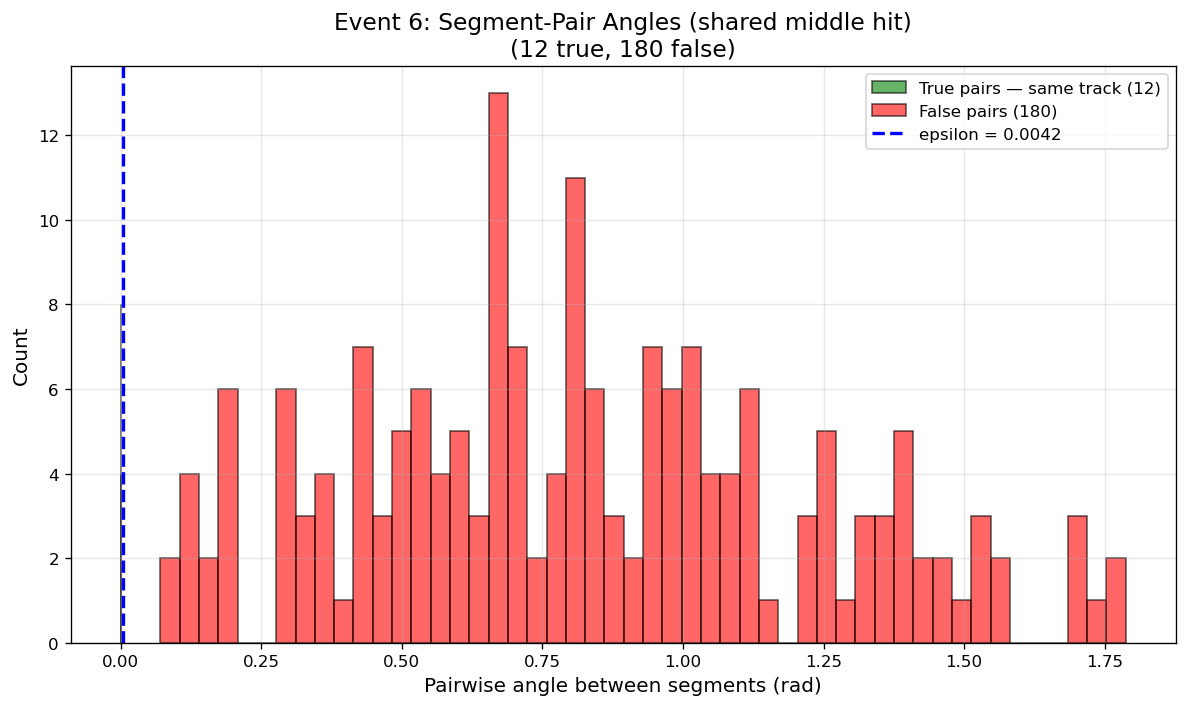

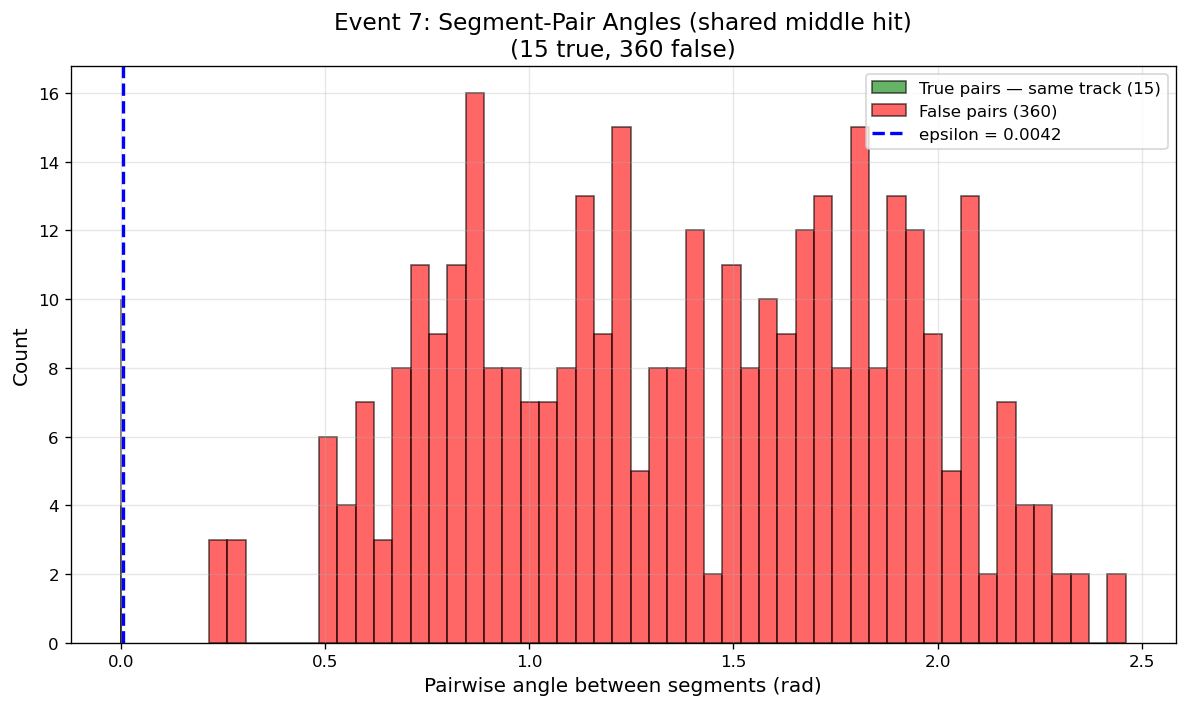

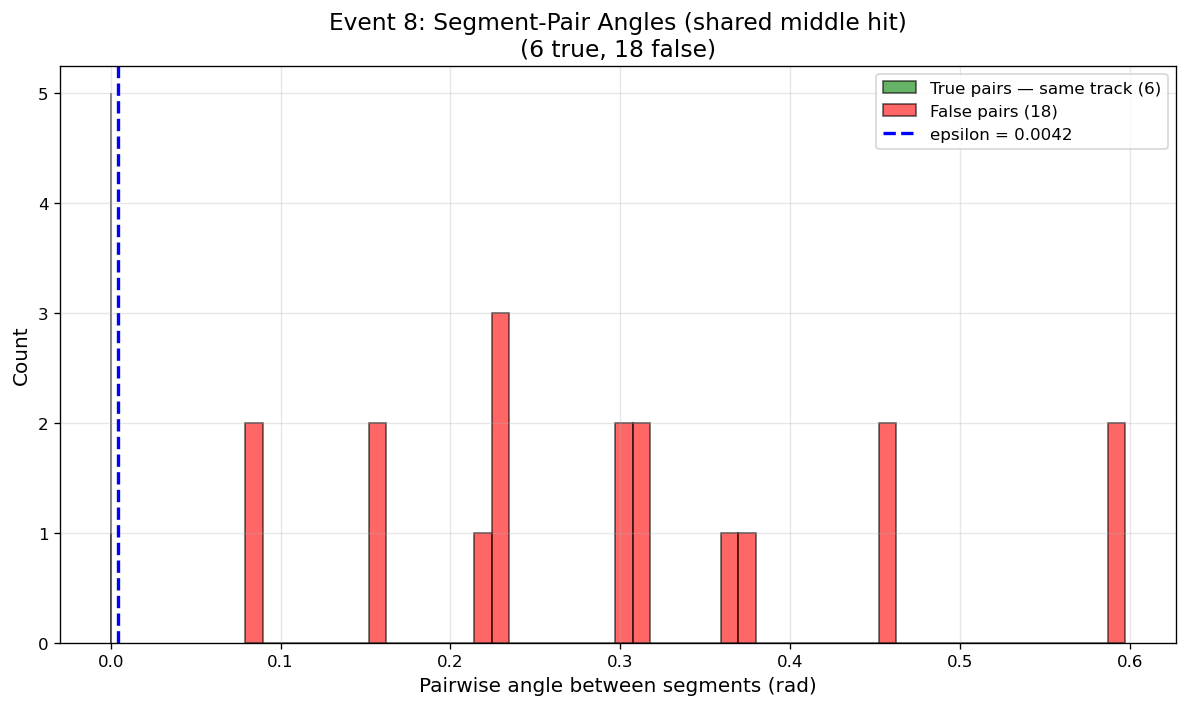

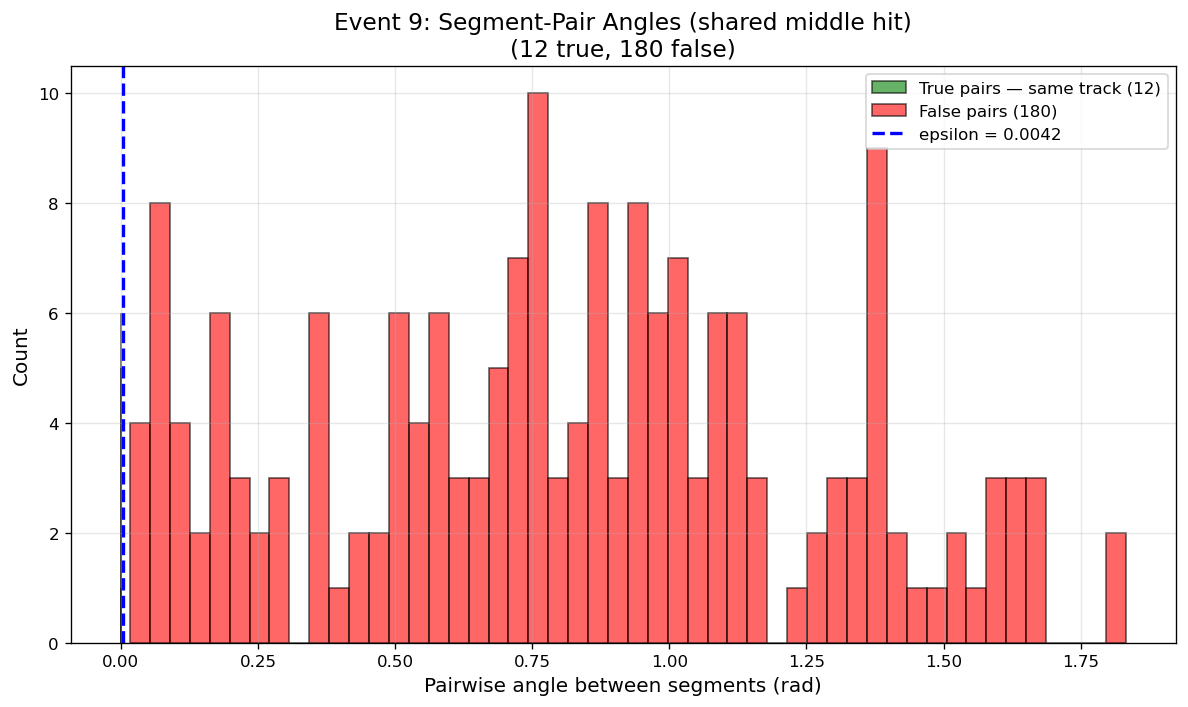

In [9]:
# ── Per-event: pairwise angles (shared middle hit) ───────────────
# Uses collect_segment_pair_angles() helper from cell 1.
# A 'true pair' = all 3 hits on the SAME track.

for ed in events_data:
    event_id = ed['event_id']
    event = ed['event']

    true_angles, false_angles = collect_segment_pair_angles(event)

    fig, ax = plt.subplots(figsize=(10, 6))
    if true_angles:
        ax.hist(true_angles, bins=50, alpha=0.6, color='green',
                label=f'True pairs — same track ({len(true_angles)})', edgecolor='black')
    if false_angles:
        ax.hist(false_angles, bins=50, alpha=0.6, color='red',
                label=f'False pairs ({len(false_angles)})', edgecolor='black')
    ax.axvline(x=EPSILON, color='blue', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
    ax.set_xlabel('Pairwise angle between segments (rad)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Event {event_id}: Segment-Pair Angles (shared middle hit)\n'
                 f'({len(true_angles)} true, {len(false_angles)} false)', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Combined: 112 true pairs (same track), 1,970 false pairs from 10 events


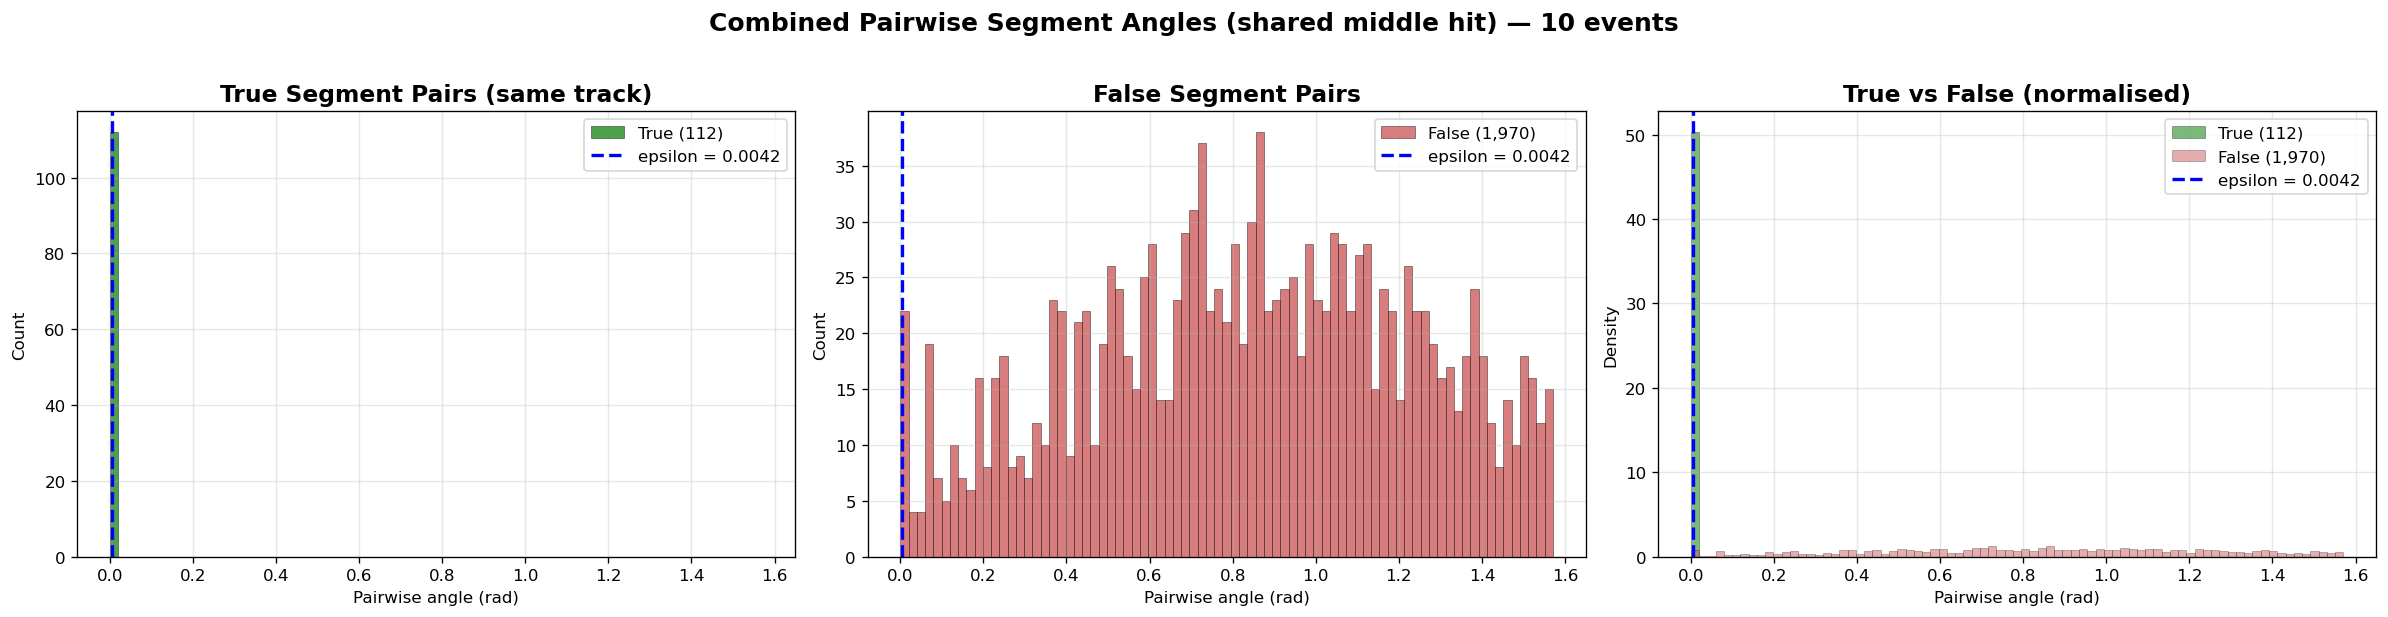

In [10]:
# ── Aggregate pairwise segment angles across ALL 10 events ──────

combined_true_angles = []
combined_false_angles = []

for ed in events_data:
    true_a, false_a = collect_segment_pair_angles(ed['event'])
    combined_true_angles.extend(true_a)
    combined_false_angles.extend(false_a)

combined_true_angles = np.array(combined_true_angles)
combined_false_angles = np.array(combined_false_angles)
print(f"Combined: {len(combined_true_angles):,} true pairs (same track), "
      f"{len(combined_false_angles):,} false pairs from {len(events_data)} events")

# ── Plot ──
bins = np.linspace(0, np.pi/2, 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].hist(combined_true_angles, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'True ({len(combined_true_angles):,})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
axes[0].set_title('True Segment Pairs (same track)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pairwise angle (rad)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=10); axes[0].grid(alpha=0.3)

axes[1].hist(combined_false_angles, bins=bins, color='indianred', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'False ({len(combined_false_angles):,})')
axes[1].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
axes[1].set_title('False Segment Pairs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pairwise angle (rad)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=10); axes[1].grid(alpha=0.3)

axes[2].hist(combined_true_angles, bins=bins, color='forestgreen', alpha=0.6,
             edgecolor='black', lw=0.3, density=True, label=f'True ({len(combined_true_angles):,})')
axes[2].hist(combined_false_angles, bins=bins, color='indianred', alpha=0.5,
             edgecolor='black', lw=0.3, density=True, label=f'False ({len(combined_false_angles):,})')
axes[2].axvline(EPSILON, color='blue', ls='--', lw=2, label=f'epsilon = {EPSILON:.4f}')
axes[2].set_title('True vs False (normalised)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Pairwise angle (rad)')
axes[2].set_ylabel('Density')
axes[2].legend(fontsize=10); axes[2].grid(alpha=0.3)

plt.suptitle(f'Combined Pairwise Segment Angles (shared middle hit) — {len(events_data)} events',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [11]:
# ── Generate 100 events x 50 tracks — pairwise segment angles ─
# Angle between segment pairs sharing a middle hit (NOT beam axis).
# True pair = all 3 hits (prev, mid, next) on the SAME track.

N_EVENTS = 100
N_TRACKS_STUDY = 50

all_true_angles = []
all_false_angles = []

for ev_i in range(N_EVENTS):
    for attempt in range(20):
        _, evt = generate_event(geo_clean, N_TRACKS_STUDY)
        if min(len(t.hit_ids) for t in evt.tracks) >= 3:
            break

    true_a, false_a = collect_segment_pair_angles(evt)
    all_true_angles.extend(true_a)
    all_false_angles.extend(false_a)

    if (ev_i + 1) % 20 == 0:
        print(f"  {ev_i + 1}/{N_EVENTS} events processed")

all_true_angles = np.array(all_true_angles)
all_false_angles = np.array(all_false_angles)
print(f"\nDone — {len(all_true_angles):,} true segment pairs, "
      f"{len(all_false_angles):,} false segment pairs "
      f"from {N_EVENTS} events x {N_TRACKS_STUDY} tracks")

  20/100 events processed
  40/100 events processed
  60/100 events processed
  80/100 events processed
  100/100 events processed

Done — 14,560 true segment pairs, 36,245,240 false segment pairs from 100 events x 50 tracks


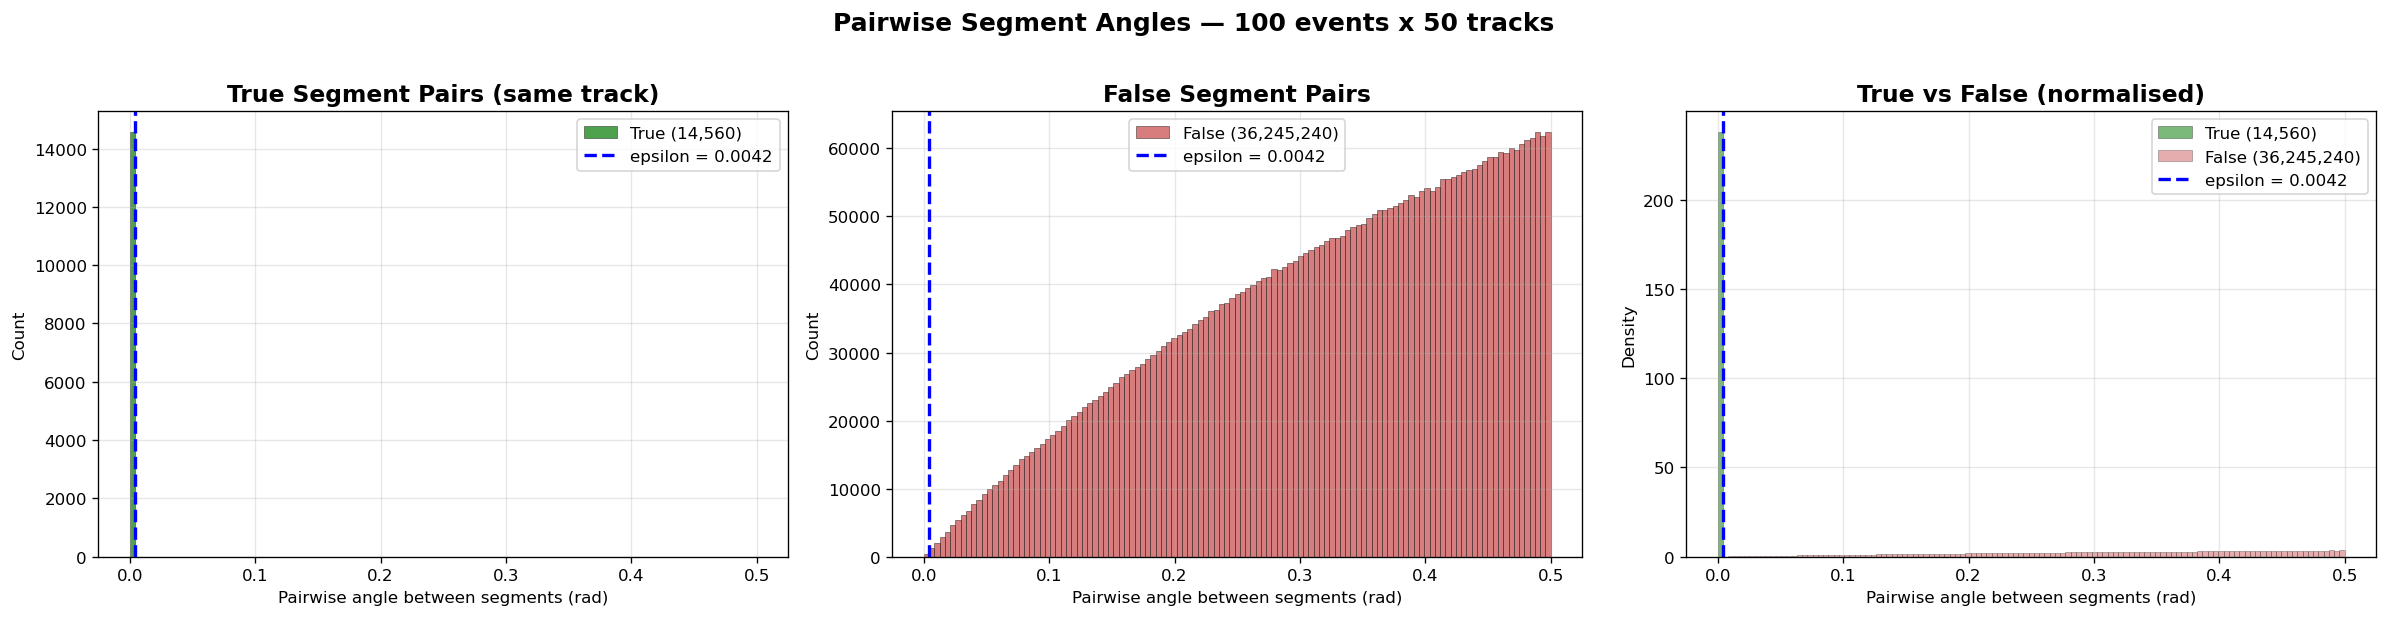

In [12]:
# ── Pairwise segment angle histograms with epsilon overlay ───────

bins = np.linspace(0, 0.5, 120)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].hist(all_true_angles, bins=bins, color='forestgreen', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'True ({len(all_true_angles):,})')
axes[0].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'epsilon = {EPSILON:.4f}')
axes[0].set_title('True Segment Pairs (same track)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pairwise angle between segments (rad)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=10); axes[0].grid(alpha=0.3)

axes[1].hist(all_false_angles, bins=bins, color='indianred', alpha=0.8,
             edgecolor='black', lw=0.3, label=f'False ({len(all_false_angles):,})')
axes[1].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'epsilon = {EPSILON:.4f}')
axes[1].set_title('False Segment Pairs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pairwise angle between segments (rad)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=10); axes[1].grid(alpha=0.3)

axes[2].hist(all_true_angles, bins=bins, color='forestgreen', alpha=0.6,
             edgecolor='black', lw=0.3, density=True,
             label=f'True ({len(all_true_angles):,})')
axes[2].hist(all_false_angles, bins=bins, color='indianred', alpha=0.5,
             edgecolor='black', lw=0.3, density=True,
             label=f'False ({len(all_false_angles):,})')
axes[2].axvline(EPSILON, color='blue', ls='--', lw=2,
                label=f'epsilon = {EPSILON:.4f}')
axes[2].set_title('True vs False (normalised)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Pairwise angle between segments (rad)')
axes[2].set_ylabel('Density')
axes[2].legend(fontsize=10); axes[2].grid(alpha=0.3)

plt.suptitle(f'Pairwise Segment Angles — {N_EVENTS} events x {N_TRACKS_STUDY} tracks',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Segment-Level Metrics vs Event Size — Scattering Comparison
Sweep track counts from 10 to 100 (step 10), 5 repeats per size.
Compare three scattering settings: 1×, 2×, 4× baseline ($\sigma_\mathrm{scatt}$ = 1e-3, 2e-3, 4e-3 rad).
Metrics: segment efficiency, false rate, pair counts, accepted pair counts.

In [13]:
# ── Scan: segment metrics vs event size — 3 scattering settings ──
import time

TRACK_SIZES    = list(range(10, 110, 10))
N_REPEATS_SCAN = 5
SCATT_MULTIPLIERS = [1, 2, 4]          # 1×, 2×, 4× baseline scattering
SIGMA_SCATT_BASE  = SIGMA_SCATT        # 1e-3 rad from cell 4

# Store results keyed by multiplier
all_scan_results = {}                   # {mult: [list of per-size dicts]}
all_epsilons     = {}                   # {mult: epsilon_value}

t0_all = time.time()

for mult in SCATT_MULTIPLIERS:
    sigma_s = SIGMA_SCATT_BASE * mult
    eps = compute_epsilon(SIGMA_RES, sigma_s, DZ_MM, scale=SCALE)
    all_epsilons[mult] = eps
    print(f"\n{'='*60}")
    print(f"  Scattering {mult}x:  sigma_scatt = {sigma_s:.1e} rad")
    print(f"  epsilon = {eps:.6f} rad  ({eps*1e3:.3f} mrad)")
    print(f"{'='*60}")

    scan_results_m = []
    t0 = time.time()

    for n_trk in TRACK_SIZES:
        per_repeat = []
        for rep in range(N_REPEATS_SCAN):
            for attempt in range(20):
                _, evt = generate_event(geo_clean, n_trk,
                                        collision_noise=sigma_s)
                if min(len(t.hit_ids) for t in evt.tracks) >= 3:
                    break

            true_angles, false_angles = collect_segment_pair_angles(evt)
            ta = np.array(true_angles)
            fa = np.array(false_angles)
            t_acc = int(np.sum(ta <= eps))
            f_acc = int(np.sum(fa <= eps))
            tot = t_acc + f_acc
            per_repeat.append({
                'n_true': len(ta), 'n_false': len(fa),
                'true_acc': t_acc,  'false_acc': f_acc,
                'eff': t_acc / len(ta) if len(ta) else 0,
                'fr':  f_acc / tot     if tot     else 0,
            })

        effs = np.array([r['eff'] for r in per_repeat])
        frs  = np.array([r['fr']  for r in per_repeat])
        se = lambda a: np.std(a, ddof=1) / np.sqrt(len(a)) if len(a) > 1 else 0.0
        scan_results_m.append({
            'n_tracks':     n_trk,
            'eff_mean':     np.mean(effs) * 100,
            'eff_se':       se(effs) * 100,
            'fr_mean':      np.mean(frs) * 100,
            'fr_se':        se(frs) * 100,
            'n_true_mean':  np.mean([r['n_true']  for r in per_repeat]),
            'n_true_se':    se(np.array([r['n_true']  for r in per_repeat], dtype=float)),
            'n_false_mean': np.mean([r['n_false'] for r in per_repeat]),
            'n_false_se':   se(np.array([r['n_false'] for r in per_repeat], dtype=float)),
            'true_acc_mean':  np.mean([r['true_acc']  for r in per_repeat]),
            'true_acc_se':    se(np.array([r['true_acc']  for r in per_repeat], dtype=float)),
            'false_acc_mean': np.mean([r['false_acc'] for r in per_repeat]),
            'false_acc_se':   se(np.array([r['false_acc'] for r in per_repeat], dtype=float)),
        })
        print(f'  {n_trk:3d} tracks  eff {scan_results_m[-1]["eff_mean"]:.1f}%  '
              f'FR {scan_results_m[-1]["fr_mean"]:.2f}%  [{time.time()-t0:.1f}s]')

    all_scan_results[mult] = scan_results_m

print(f'\nAll scans done in {time.time()-t0_all:.1f}s')
for mult in SCATT_MULTIPLIERS:
    eps = all_epsilons[mult]
    print(f'  {mult}x scattering: epsilon = {eps*1e3:.3f} mrad')


  Scattering 1x:  sigma_scatt = 1.0e-03 rad
  epsilon = 0.004243 rad  (4.243 mrad)
   10 tracks  eff 100.0%  FR 0.00%  [0.3s]
   20 tracks  eff 100.0%  FR 0.00%  [2.9s]
   30 tracks  eff 100.0%  FR 0.43%  [11.7s]
   40 tracks  eff 100.0%  FR 2.83%  [32.5s]
   50 tracks  eff 100.0%  FR 2.28%  [72.2s]
   60 tracks  eff 100.0%  FR 1.88%  [140.1s]
   70 tracks  eff 100.0%  FR 15.92%  [254.4s]
   80 tracks  eff 100.0%  FR 17.29%  [426.3s]
   90 tracks  eff 100.0%  FR 5.69%  [664.8s]
  100 tracks  eff 99.9%  FR 7.93%  [996.4s]

  Scattering 2x:  sigma_scatt = 2.0e-03 rad
  epsilon = 0.008485 rad  (8.485 mrad)
   10 tracks  eff 100.0%  FR 0.65%  [0.4s]
   20 tracks  eff 100.0%  FR 1.30%  [3.0s]
   30 tracks  eff 100.0%  FR 3.49%  [11.7s]
   40 tracks  eff 99.8%  FR 1.44%  [30.6s]
   50 tracks  eff 100.0%  FR 15.11%  [73.2s]
   60 tracks  eff 100.0%  FR 24.91%  [145.4s]
   70 tracks  eff 100.0%  FR 11.60%  [259.7s]
   80 tracks  eff 100.0%  FR 16.71%  [429.6s]
   90 tracks  eff 100.0%  FR 18.

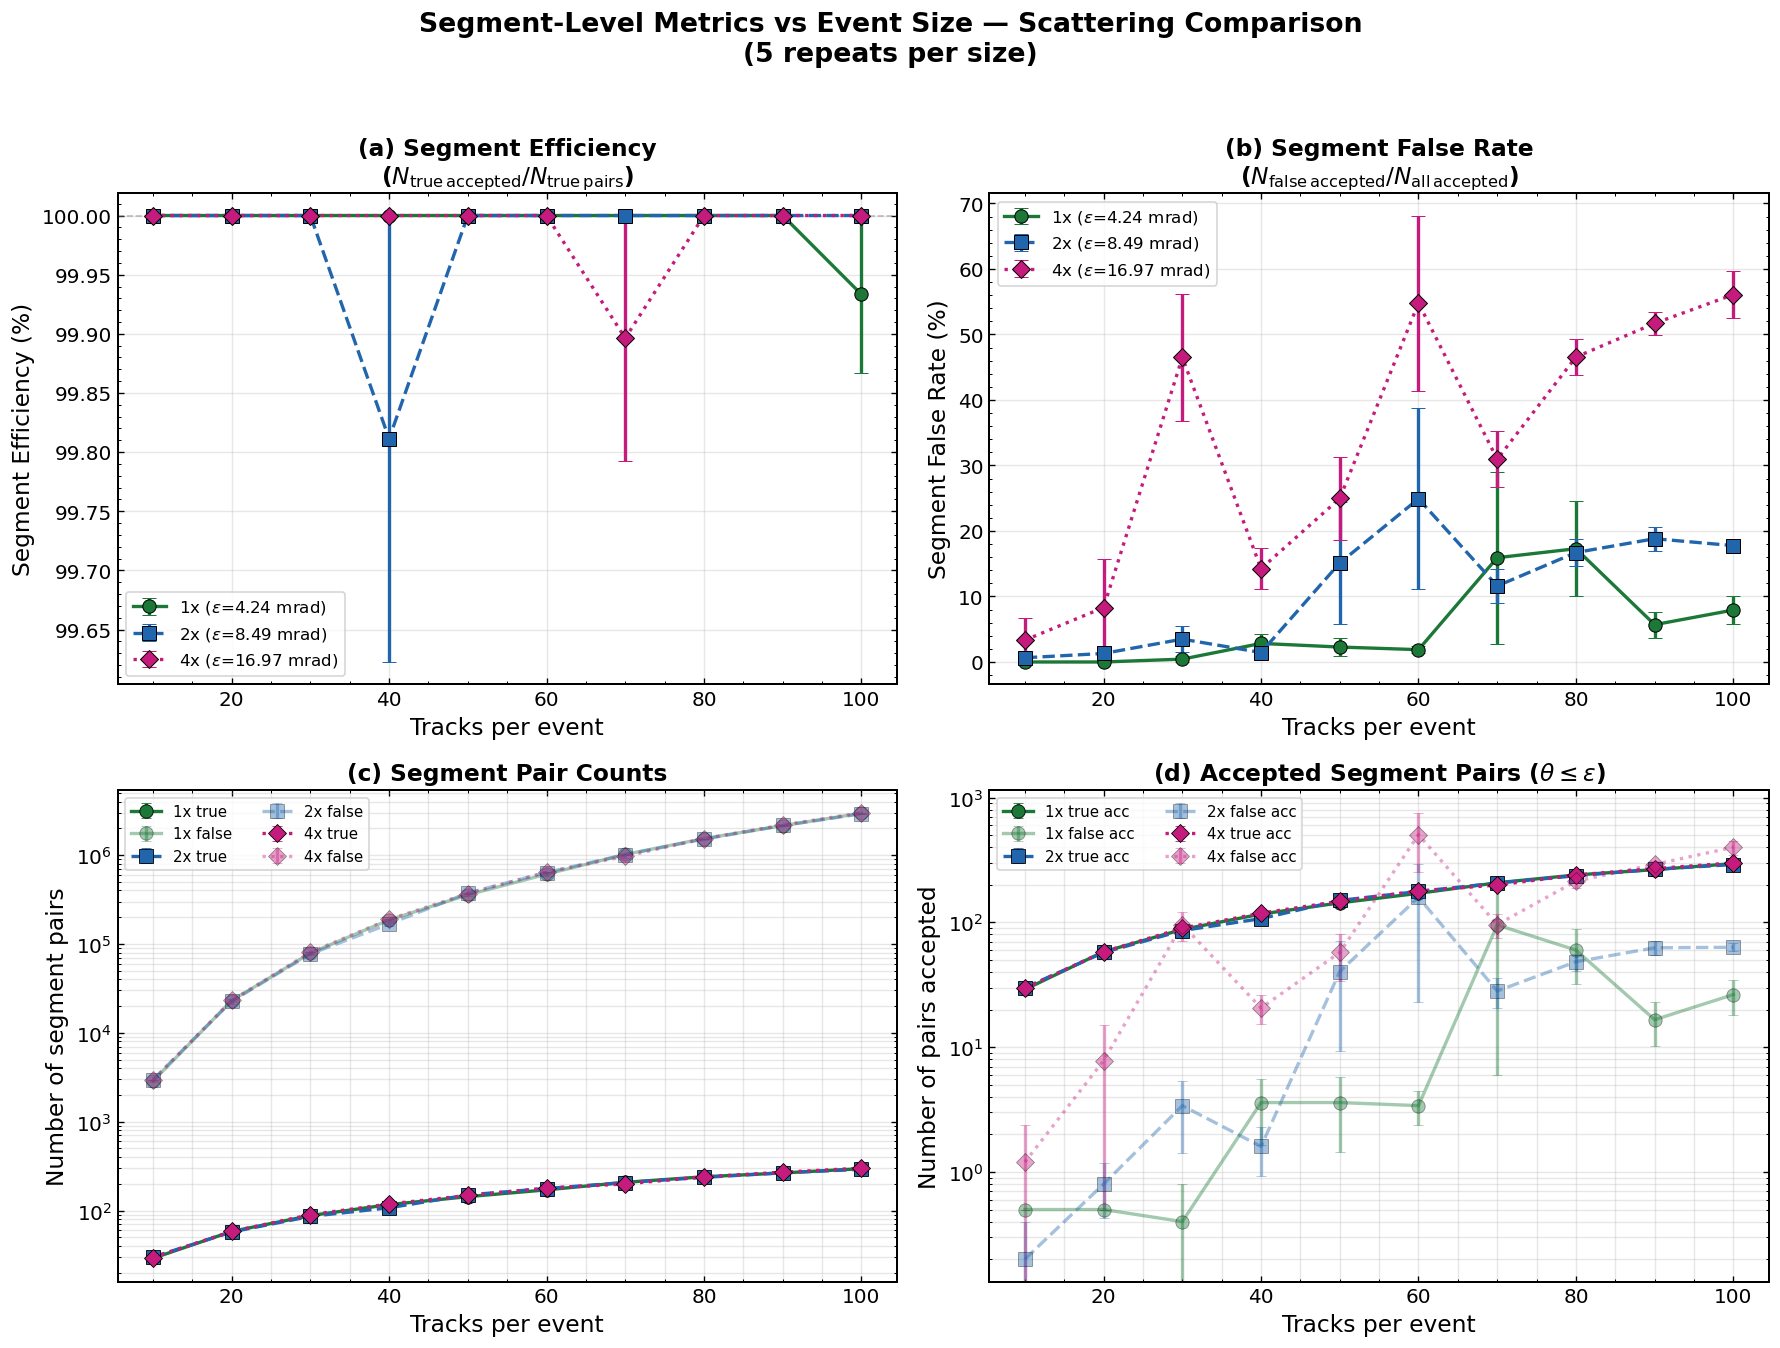


  1x scattering  (sigma_scatt=1.0e-03, epsilon=4.243 mrad)
 Tracks      Eff (%)       FR (%)     True pairs    False pairs       True acc      False acc
-----------------------------------------------------------------------------------------------
     10   100.0+/-0.00    0.00+/-0.00       29+/-1     2855+/-76       29+/-1        0+/-0
     20   100.0+/-0.00    0.00+/-0.00       58+/-1    23030+/-727       58+/-1        0+/-0
     30   100.0+/-0.00    0.43+/-0.43       88+/-2    78932+/-1404       88+/-2        0+/-0
     40   100.0+/-0.00    2.83+/-1.49      117+/-2   186443+/-3561      117+/-2        4+/-2
     50   100.0+/-0.00    2.28+/-1.32      143+/-4   357427+/-11818      143+/-4        4+/-2
     60   100.0+/-0.00    1.88+/-0.53      171+/-7   609813+/-31164      171+/-7        3+/-1
     70   100.0+/-0.00   15.92+/-13.10      208+/-2  1018012+/-10778      208+/-2       95+/-89
     80   100.0+/-0.00   17.29+/-7.21      240+/-0  1535760+/-0      240+/-0       60+/-28
     9

In [14]:
# ── Plot: segment metrics vs event size — scattering comparison ──
plt.rcParams.update({
    'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 14,
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 11,
    'axes.linewidth': 1.2, 'lines.linewidth': 2, 'lines.markersize': 8,
})

# One colour per scattering multiplier
scatter_colors = {1: '#1b7837', 2: '#2166ac', 4: '#c51b7d'}
scatter_fmts   = {1: 'o-',     2: 's--',     4: 'D:'}

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

for mult in SCATT_MULTIPLIERS:
    results = all_scan_results[mult]
    eps = all_epsilons[mult]
    col = scatter_colors[mult]
    fmt = scatter_fmts[mult]
    lbl = f'{mult}x ($\\varepsilon$={eps*1e3:.2f} mrad)'

    x_tracks = np.array([r['n_tracks'] for r in results])

    # ── (a) Segment Efficiency ──
    ax = axes[0, 0]
    eff_mean = np.array([r['eff_mean'] for r in results])
    eff_se   = np.array([r['eff_se']   for r in results])
    ax.errorbar(x_tracks, eff_mean, yerr=eff_se, fmt=fmt, color=col,
                capsize=4, capthick=1.2, markeredgecolor='black',
                markeredgewidth=0.6, label=lbl)

    # ── (b) False Rate ──
    ax = axes[0, 1]
    fr_mean = np.array([r['fr_mean'] for r in results])
    fr_se   = np.array([r['fr_se']   for r in results])
    ax.errorbar(x_tracks, fr_mean, yerr=fr_se, fmt=fmt, color=col,
                capsize=4, capthick=1.2, markeredgecolor='black',
                markeredgewidth=0.6, label=lbl)

    # ── (c) Segment Pair Counts ──
    ax = axes[1, 0]
    n_true_m  = np.array([r['n_true_mean']  for r in results])
    n_true_e  = np.array([r['n_true_se']    for r in results])
    n_false_m = np.array([r['n_false_mean'] for r in results])
    n_false_e = np.array([r['n_false_se']   for r in results])
    ax.errorbar(x_tracks, n_true_m,  yerr=n_true_e,  fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, label=f'{mult}x true')
    ax.errorbar(x_tracks, n_false_m, yerr=n_false_e, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, alpha=0.4, label=f'{mult}x false')

    # ── (d) Accepted Pair Counts ──
    ax = axes[1, 1]
    ta_m = np.array([r['true_acc_mean']  for r in results])
    ta_e = np.array([r['true_acc_se']    for r in results])
    fa_m = np.array([r['false_acc_mean'] for r in results])
    fa_e = np.array([r['false_acc_se']   for r in results])
    fa_m_plot = np.where(fa_m > 0, fa_m, 0.5)
    fa_e_plot = np.where(fa_m > 0, fa_e, 0)
    ax.errorbar(x_tracks, ta_m, yerr=ta_e, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, label=f'{mult}x true acc')
    ax.errorbar(x_tracks, fa_m_plot, yerr=fa_e_plot, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, alpha=0.4, label=f'{mult}x false acc')

# ── Axis formatting ──
axes[0, 0].axhline(100, color='gray', ls='--', lw=1, alpha=0.5)
axes[0, 0].set_xlabel('Tracks per event')
axes[0, 0].set_ylabel('Segment Efficiency (%)')
axes[0, 0].set_title('(a) Segment Efficiency\n'
                      r'($N_{\mathrm{true\,accepted}} / N_{\mathrm{true\,pairs}}$)',
                      fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='lower left')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].minorticks_on()
axes[0, 0].tick_params(which='both', direction='in', top=True, right=True)

axes[0, 1].set_xlabel('Tracks per event')
axes[0, 1].set_ylabel('Segment False Rate (%)')
axes[0, 1].set_title('(b) Segment False Rate\n'
                      r'($N_{\mathrm{false\,accepted}} / N_{\mathrm{all\,accepted}}$)',
                      fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].minorticks_on()
axes[0, 1].tick_params(which='both', direction='in', top=True, right=True)

for ax_idx in [(1, 0), (1, 1)]:
    axes[ax_idx].set_yscale('log')
    axes[ax_idx].set_xlabel('Tracks per event')
    axes[ax_idx].grid(True, alpha=0.3, which='both')
    axes[ax_idx].minorticks_on()
    axes[ax_idx].tick_params(which='both', direction='in', top=True, right=True)

axes[1, 0].set_ylabel('Number of segment pairs')
axes[1, 0].set_title('(c) Segment Pair Counts', fontweight='bold')
axes[1, 0].legend(fontsize=9, ncol=2, loc='upper left')

axes[1, 1].set_ylabel('Number of pairs accepted')
axes[1, 1].set_title(r'(d) Accepted Segment Pairs ($\theta \leq \varepsilon$)',
                      fontweight='bold')
axes[1, 1].legend(fontsize=9, ncol=2, loc='upper left')

fig.suptitle('Segment-Level Metrics vs Event Size — Scattering Comparison\n'
             f'({N_REPEATS_SCAN} repeats per size)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ── Summary tables ──
for mult in SCATT_MULTIPLIERS:
    eps = all_epsilons[mult]
    results = all_scan_results[mult]
    print(f"\n{'='*95}")
    print(f"  {mult}x scattering  (sigma_scatt={SIGMA_SCATT_BASE*mult:.1e}, "
          f"epsilon={eps*1e3:.3f} mrad)")
    print(f"{'='*95}")
    print(f"{'Tracks':>7} {'Eff (%)':>12} {'FR (%)':>12} "
          f"{'True pairs':>14} {'False pairs':>14} "
          f"{'True acc':>14} {'False acc':>14}")
    print('-' * 95)
    for r in results:
        print(f"{r['n_tracks']:7d} "
              f"{r['eff_mean']:7.1f}+/-{r['eff_se']:.2f} "
              f"{r['fr_mean']:7.2f}+/-{r['fr_se']:.2f} "
              f"{r['n_true_mean']:8.0f}+/-{r['n_true_se']:.0f} "
              f"{r['n_false_mean']:8.0f}+/-{r['n_false_se']:.0f} "
              f"{r['true_acc_mean']:8.0f}+/-{r['true_acc_se']:.0f} "
              f"{r['false_acc_mean']:8.0f}+/-{r['false_acc_se']:.0f}")

1x scattering: 2,928 true pairs (2,928 accepted), 7,306,172 false pairs (64 accepted)  [eps=4.24 mrad]
2x scattering: 2,929 true pairs (2,929 accepted), 7,302,871 false pairs (211 accepted)  [eps=8.49 mrad]
4x scattering: 2,899 true pairs (2,898 accepted), 7,214,801 false pairs (1,330 accepted)  [eps=16.97 mrad]


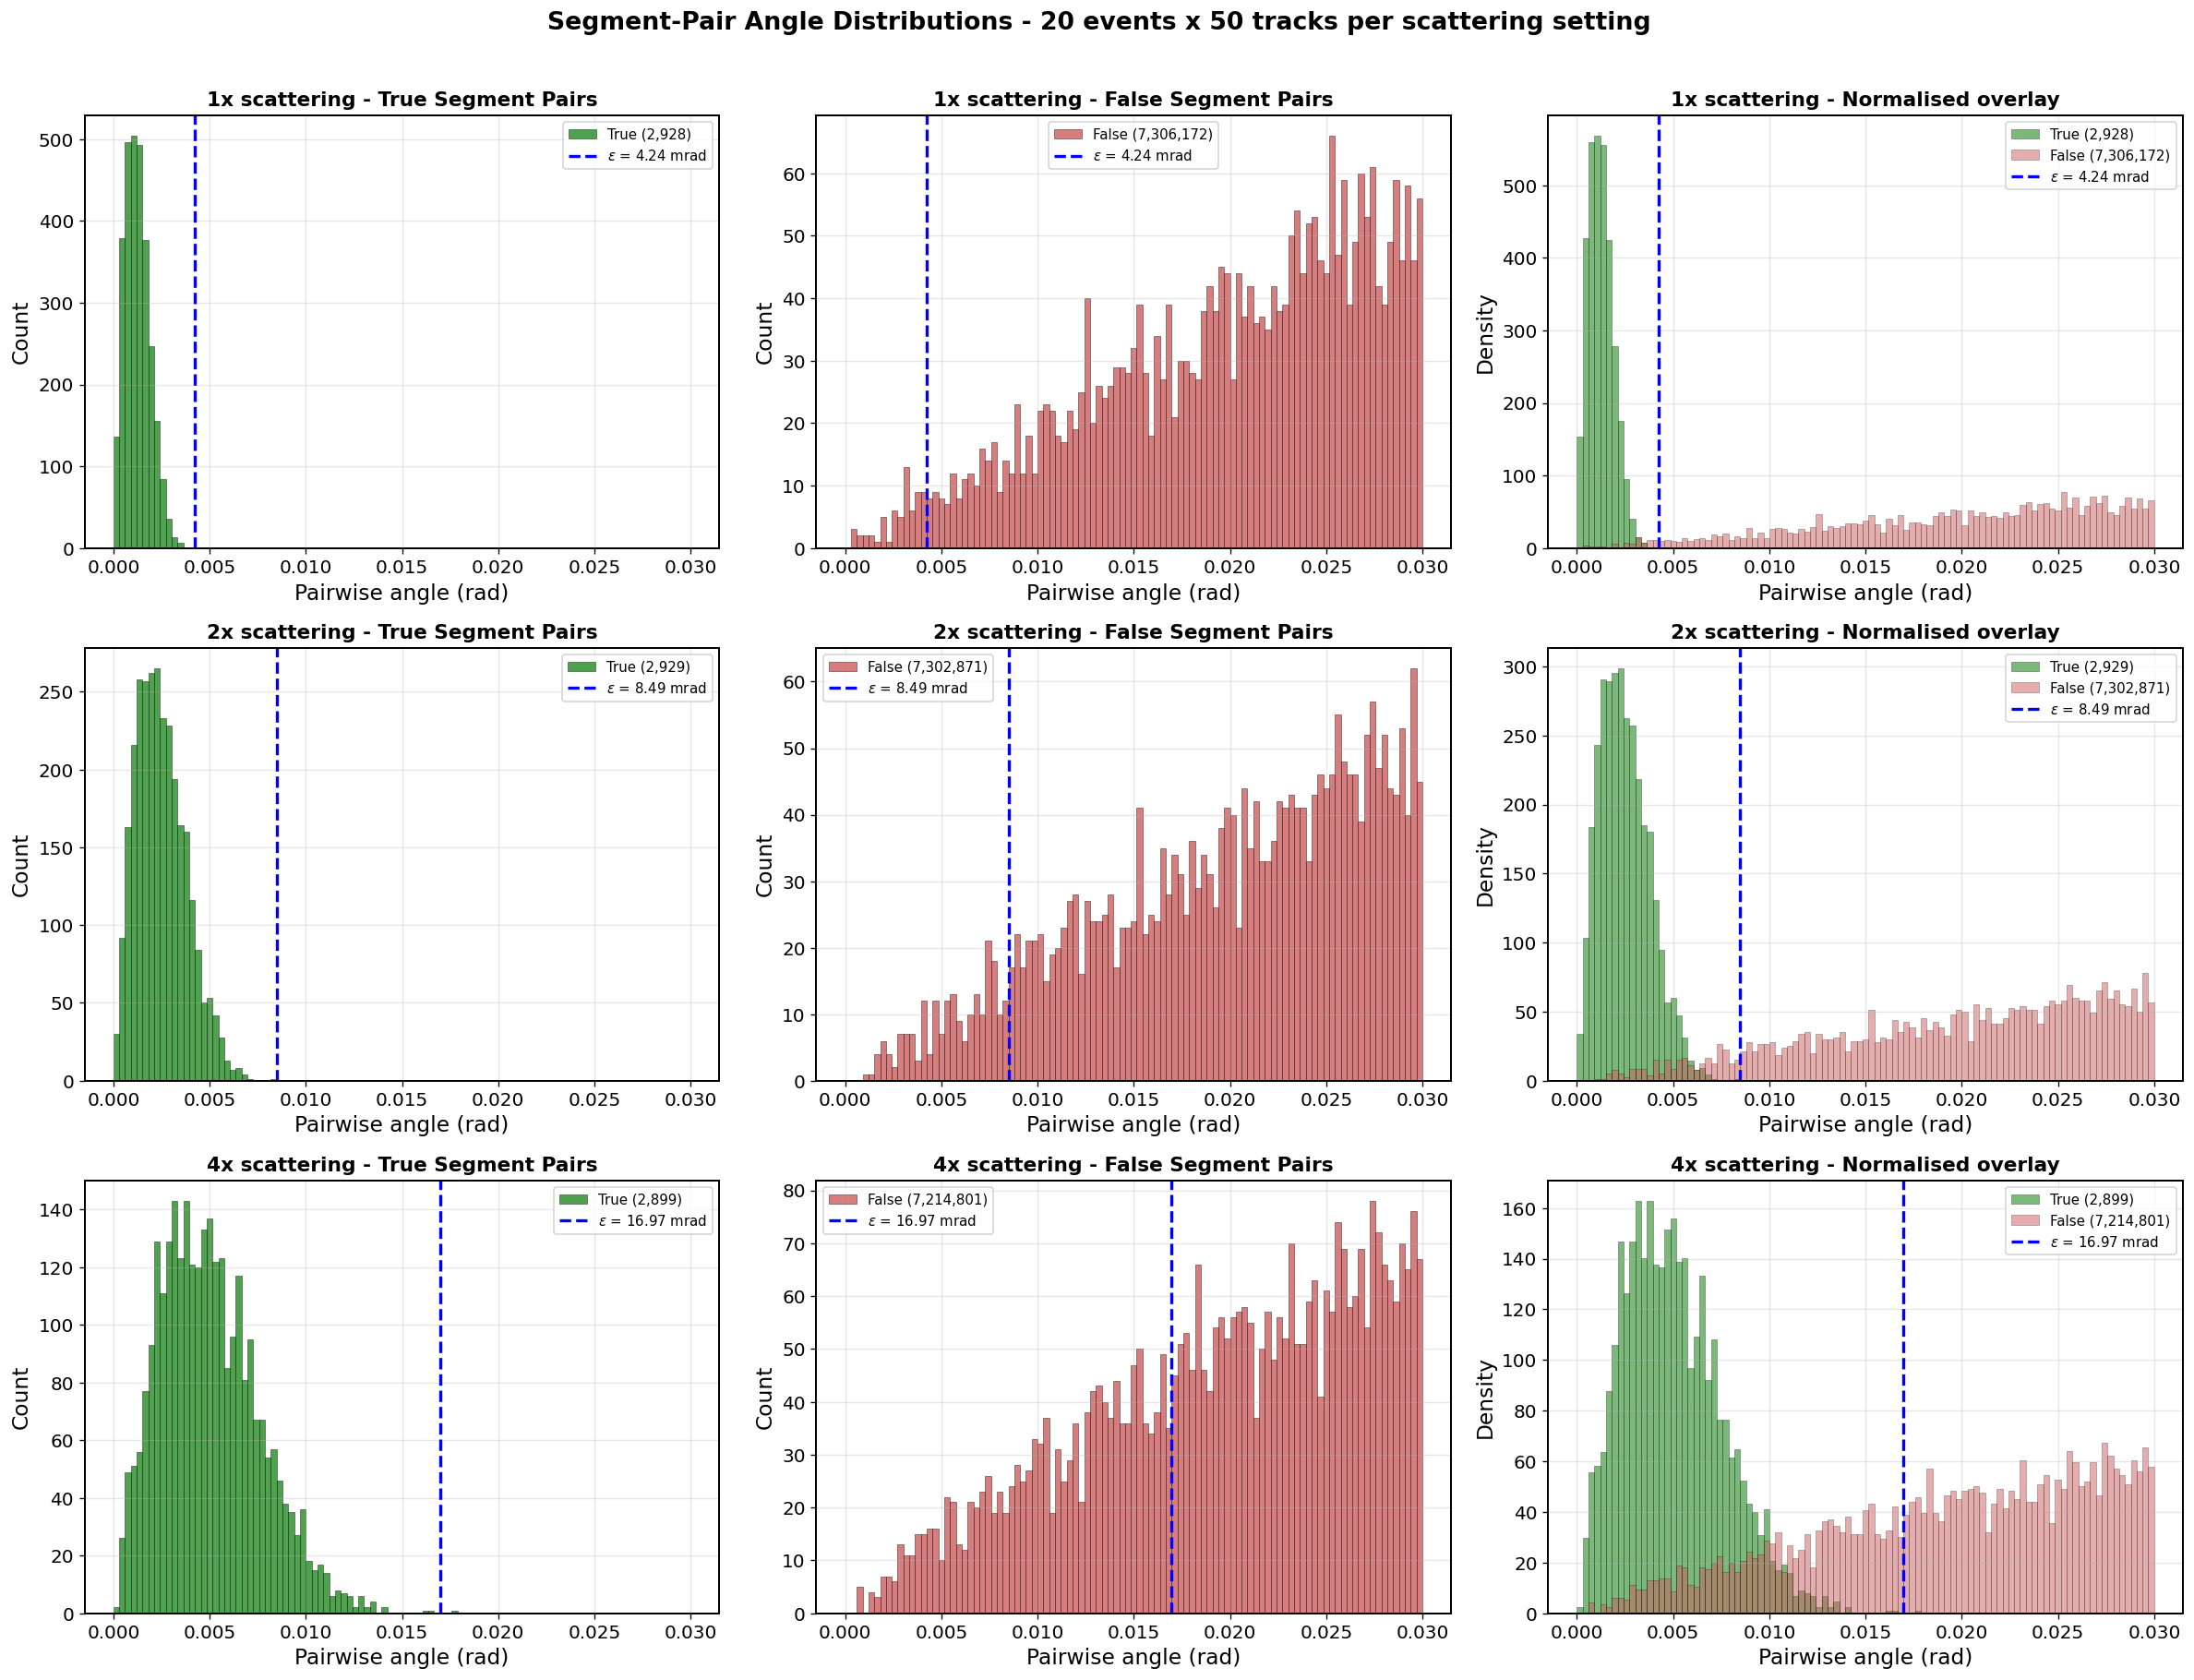

In [15]:
# ── Acceptance histograms: true vs false angles for 3 scattering settings ──
# Generate 50-track events (20 repeats) per scattering setting and collect angles.

N_TRACKS_HIST = 50
N_EVENTS_HIST = 20

hist_data = {}   # {mult: {'true': [...], 'false': [...]}}

for mult in SCATT_MULTIPLIERS:
    sigma_s = SIGMA_SCATT_BASE * mult
    eps = all_epsilons[mult]
    all_true, all_false = [], []

    for ev_i in range(N_EVENTS_HIST):
        for attempt in range(20):
            _, evt = generate_event(geo_clean, N_TRACKS_HIST,
                                    collision_noise=sigma_s)
            if min(len(t.hit_ids) for t in evt.tracks) >= 3:
                break
        ta, fa = collect_segment_pair_angles(evt)
        all_true.extend(ta)
        all_false.extend(fa)

    hist_data[mult] = {
        'true':  np.array(all_true),
        'false': np.array(all_false),
    }
    t_below = np.sum(hist_data[mult]['true'] <= eps)
    f_below = np.sum(hist_data[mult]['false'] <= eps)
    print(f"{mult}x scattering: {len(all_true):,} true pairs "
          f"({t_below:,} accepted), "
          f"{len(all_false):,} false pairs "
          f"({f_below:,} accepted)  "
          f"[eps={eps*1e3:.2f} mrad]")

# ── Plot: 3 rows (one per scattering) x 3 columns ──
fig, axes = plt.subplots(len(SCATT_MULTIPLIERS), 3,
                         figsize=(20, 5 * len(SCATT_MULTIPLIERS)))

x_max_rad = 0.03   # zoom range for histograms
bins = np.linspace(0, x_max_rad, 100)

for row, mult in enumerate(SCATT_MULTIPLIERS):
    eps = all_epsilons[mult]
    ta = hist_data[mult]['true']
    fa = hist_data[mult]['false']

    # (left) True segment-pair angles
    ax = axes[row, 0]
    ax.hist(ta, bins=bins, color='forestgreen', alpha=0.8,
            edgecolor='black', lw=0.3,
            label=f'True ({len(ta):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - True Segment Pairs',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # (middle) False segment-pair angles
    ax = axes[row, 1]
    ax.hist(fa, bins=bins, color='indianred', alpha=0.8,
            edgecolor='black', lw=0.3,
            label=f'False ({len(fa):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - False Segment Pairs',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # (right) Overlay normalised
    ax = axes[row, 2]
    ax.hist(ta, bins=bins, color='forestgreen', alpha=0.6,
            edgecolor='black', lw=0.3, density=True,
            label=f'True ({len(ta):,})')
    ax.hist(fa, bins=bins, color='indianred', alpha=0.5,
            edgecolor='black', lw=0.3, density=True,
            label=f'False ({len(fa):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - Normalised overlay',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle(f'Segment-Pair Angle Distributions - {N_EVENTS_HIST} events x '
             f'{N_TRACKS_HIST} tracks per scattering setting',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()